<a href="https://colab.research.google.com/github/dannynacker/strobe_depression/blob/main/WP2_strat_and_monitor_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WP2 EM-DRATS (Environment for the Monitoring of Demographics, Retention, Affect, Tolerability, and Stratification)

requires:
Drop out questions_XXX.csv
wp2_post_session_4_XXX.csv
wp2_post_sessions_1-3_XXX.csv
wp2_pre_screen_XXX.csv
wp2_pre_session_1_XXX.csv
wp2_pre_sessions_2-4_XXX.csv
wp2_sms_day1,3,5_XXX.csv
wp2_sms_post_XXX.csv

creates:
wp2_assignments.csv
stratified & blinded sequence name per new participant ID
monitoring of wellbeing & tolerability
monitoring of demographic data, exclusion & retention rate

script 1: sign-up, demographic, retention (not for researcher use -- PI use only)
- run after running script 2 as it requires wp2_assignments

script 2: main blind stratification script (for researcher use)
- requires pre-screen CSV and creates list of blinded sequence names per new successful bookings (calendly_event_booked)
- below it is a stratification balance check, though it exposes number of strata per condition, so may unblind (not for researcher use -- PI use only)
- below the stratification balance check is the fixed seed (=42) through which our 5 control and 5 intervention sequences were renamed -- no need to ever run this again

script 3: main longitudinal wellbeing monitoring per condition/measure (not for researcher use -- PI use only)
- requires all 7 wellbeing CSVs
- plots per measure per condition with "worsening" part_ids outlined in summary tables below each measure plot
- used to see when clinicians should reach out to specific participants (touch base with researcher to link part_id to email)

script 4: main tolerability monitoring per condition (for any use)
- requires all post-session CSVs to make sure that session tolerability never exceeds our specified threshold
- future updates will incorporate FIBSER ratings? unsure

# WP2 Sign-Up & Retention Data Monitoring
*   requires wp2_pre_screen_XXX.CSV
*   requires drop out questions_XXX.CSV
*   requires wp2_assignments.CSV from stratification script
*   monitors passed/excluded as well as retention rate








In [12]:
import pandas as pd
from pathlib import Path
from IPython.display import display

#####
# Setup
#####
DATA_DIR = Path('/content')

def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 0) Load assignments
#####
assign = pd.read_csv(find_csv('wp2_assignments'), dtype=str)

#####
# 0.1) Define manual‐exclusion list
# — either hard‐code IDs here:
MANUAL_EXCLUDE_IDS = {
    "11274" # unable to make first session; excluding preliminarily
    # etc…
}

#####
# 1) Load & summarize pre‐screening
#####
df_pre = pd.read_csv(find_csv('wp2_pre_screen_'), dtype=str)
df_pre = df_pre.merge(
    assign[['part_id','condition','sequence_name']],
    on='part_id', how='left'
)

# 1.1) Drop your never‐attended exclusions before any summaries
df_pre = df_pre[~df_pre['part_id'].isin(MANUAL_EXCLUDE_IDS)].copy()

# 1a) Exclusion counts
excluded_counts = df_pre['excluded'].value_counts()
passed_count    = excluded_counts.get('FALSE', 0)
safety_excl     = excluded_counts.get('safety_screening', 0)
demo_excl       = excluded_counts.get('demographics', 0)

summary_excl = pd.DataFrame({
    'Category': [
        '# Passed pre-screen',
        '# Excluded for safety',
        '# Excluded for demographics'
    ],
    'Count': [
        passed_count,
        safety_excl,
        demo_excl
    ]
})
print("=== Pre-screen Exclusion Summary ===")
display(summary_excl)

# 1b) Demographics for Passed vs. Failed
df_pre['incl_dem_age'] = pd.to_numeric(df_pre['incl_dem_age'], errors='coerce')
df_pre['phq9_sum']     = pd.to_numeric(df_pre['phq9_sum'], errors='coerce')
df_pre['incl_dem_sex'] = df_pre['incl_dem_sex'].str.strip().str.lower()
valid_sex = ['male','female','other']
df_pre.loc[~df_pre['incl_dem_sex'].isin(valid_sex), 'incl_dem_sex'] = pd.NA

passed_df = df_pre[df_pre['excluded']=='FALSE']
failed_df = df_pre[df_pre['excluded']!='FALSE']

def summarize_group(group_df, title):
    print(f"\n=== {title} ===")
    mean_age = group_df['incl_dem_age'].mean()
    sd_age   = group_df['incl_dem_age'].std()
    print(f"Age (years)    Mean ± SD: {mean_age:.2f} ± {sd_age:.2f}")
    mean_phq = group_df['phq9_sum'].mean()
    sd_phq   = group_df['phq9_sum'].std()
    print(f"PHQ-9 Sum      Mean ± SD: {mean_phq:.2f} ± {sd_phq:.2f}")
    print("\nSex Breakdown:")
    sex_counts = (
        group_df['incl_dem_sex']
          .value_counts(dropna=True)
          .rename_axis('Sex')
          .reset_index(name='Count')
    )
    display(sex_counts)

summarize_group(passed_df, "Passed Participants")
summarize_group(failed_df, "Failed Participants")

#####
# 2) Who actually signed up (session1_pre) – overall, by condition, and retention
#####
df_s1 = pd.read_csv(find_csv('wp2_pre_session_1'), dtype=str)
df_s1 = df_s1.merge(
    assign[['part_id','condition','sequence_name']],
    on='part_id', how='left'
)

# 2.1) Drop the same manual exclusions here
df_s1 = df_s1[~df_s1['part_id'].isin(MANUAL_EXCLUDE_IDS)].copy()

df_s1['part_id_clean'] = df_s1['part_id'].str.strip()
passed_ids   = set(passed_df['part_id'])
real_signed  = set(df_s1['part_id_clean']) & passed_ids

# filter to only participants who passed and signed
df_s1_passed = df_s1[df_s1['part_id_clean'].isin(real_signed)]

signed_count = len(real_signed)
retention    = signed_count / passed_count if passed_count else 0

print(f"Of the {passed_count} who passed pre-screen, "
      f"{signed_count} actually signed up for Session 1.")
print(f"Overall retention: {retention:.1%}\n")

# breakdown by arm, counting unique participants
print("=== Sign-ups by Condition (only passed) ===")
sign_counts = (
    df_s1_passed
      .groupby('condition')['part_id_clean']
      .nunique()
      .rename('N_signups')
      .reset_index()
)
passed_by_cond = (
    passed_df
      .groupby('condition')['part_id']
      .nunique()
      .rename('N_passed')
      .reset_index()
)
ret_by_cond = pd.merge(sign_counts, passed_by_cond, on='condition')
ret_by_cond['Retention'] = ret_by_cond['N_signups'] / ret_by_cond['N_passed']
display(ret_by_cond)

#####
# 3) Summarize drop-out reasons – overall & by condition
#####
df_drop = pd.read_csv(find_csv('Drop out questions_'), dtype=str)

# unify and clean the ID column
id_cols = [c for c in df_drop.columns
           if c.lower() in ('part_id','responseid','externalreference','participantid','id')]
true_id = ( [c for c in id_cols if c=='part_id'] or [id_cols[0]] )[0]
df_drop = df_drop.rename(columns={true_id:'part_id'})
df_drop = df_drop.loc[:,~df_drop.columns.duplicated()]
df_drop['part_id'] = df_drop['part_id'].str.strip()

def map_reason(text):
    if pd.isna(text): return 'unknown'
    t = text.strip()
    if t in (
      "I found the strobe experiences uncomfortable",
      "I believe I experienced some negative side effects from the strobe sessions"):
        return 'tolerability'
    if t == "I found coming to the appointment(s) too difficult":
        return 'scheduling'
    if t.startswith("I did not enjoy the study for other reasons"):
        return 'other'
    return 'unknown'

df_drop['reason_cat'] = df_drop['drop_out_why'].apply(map_reason)
df_drop = df_drop.merge(assign[['part_id','condition']], on='part_id', how='left')
drop_unique = df_drop[['part_id','condition','reason_cat']].drop_duplicates('part_id')

# overall drop-out
n_dropped    = drop_unique['part_id'].nunique()
drop_counts  = drop_unique['reason_cat'].value_counts().reindex(
                   ['tolerability','scheduling','other'], fill_value=0)
drop_summary = pd.DataFrame({
    'Reason': ['Side-effects / tolerability','Scheduling issues','Other'],
    'Count':  drop_counts.values
})
print(f"=== Drop-out Reasons (Overall: {n_dropped} of {signed_count} dropped) ===")
display(drop_summary)

# drop-out by arm
print("\n=== Drop-out by Condition ===")
drop_by_cond = (
    drop_unique
      .groupby(['condition','reason_cat'])['part_id']
      .nunique()
      .unstack(fill_value=0)
      .reindex(
         index=['control','intervention'],
         columns=['tolerability','scheduling','other'],
         fill_value=0
      )
)
dropped_per_arm = drop_unique.groupby('condition')['part_id'].nunique().rename('Dropped')
sign_per_arm    = ret_by_cond.set_index('condition')['N_signups']
drop_by_cond['Dropped']   = dropped_per_arm
drop_by_cond['Retention'] = 1 - (drop_by_cond['Dropped'] / sign_per_arm)
display(drop_by_cond)

#####
# 4) Narrative summary
#####
def get_retention_stats(df, condition):
    cond_df = df[df['condition']==condition]
    if cond_df.empty:
        return (0,0,0)
    return (
        cond_df['N_signups'].iat[0],
        cond_df['N_passed'].iat[0],
        cond_df['Retention'].iat[0]
    )

int_signups, int_passed, int_ret = get_retention_stats(ret_by_cond, 'intervention')
ctrl_signups, ctrl_passed, ctrl_ret = get_retention_stats(ret_by_cond, 'control')

int_dropped = dropped_per_arm.get('intervention', 0)
int_signed  = sign_per_arm.get('intervention', 1)
ctrl_dropped= dropped_per_arm.get('control', 0)
ctrl_signed = sign_per_arm.get('control', 1)

print(f"""
Summary:
- {passed_count} passed the pre-screen.
- {signed_count} of those ({retention:.1%}) signed up for Session 1.
- Sign-ups by arm:
    • Intervention: {int_signups}/{int_passed} ({int_ret:.1%})
    • Control:      {ctrl_signups}/{ctrl_passed} ({ctrl_ret:.1%})
- Overall drop-out: {n_dropped} of {signed_count} dropped (retention {1-(n_dropped/signed_count):.1%})
- Drop-out by arm:
    • Intervention: {int_dropped}/{int_signed} dropped ({1-(int_dropped/int_signed):.1%} retention)
    • Control:      {ctrl_dropped}/{ctrl_signed} dropped ({1-(ctrl_dropped/ctrl_signed):.1%} retention)
""")

=== Pre-screen Exclusion Summary ===


Category  Count
0          # Passed pre-screen    100
1        # Excluded for safety     20
2  # Excluded for demographics     19


=== Passed Participants ===
Age (years)    Mean ± SD: 29.45 ± 11.03
PHQ-9 Sum      Mean ± SD: 13.36 ± 4.13

Sex Breakdown:


Sex  Count
0  female     35
1    male     21


=== Failed Participants ===
Age (years)    Mean ± SD: 26.84 ± 5.95
PHQ-9 Sum      Mean ± SD: 12.36 ± 5.91

Sex Breakdown:


Sex  Count
0  female     11
1    male      8

Of the 100 who passed pre-screen, 23 actually signed up for Session 1.
Overall retention: 23.0%

=== Sign-ups by Condition (only passed) ===


condition  N_signups  N_passed  Retention
0       control          8        13   0.615385
1  intervention         13        18   0.722222

=== Drop-out Reasons (Overall: 2 of 23 dropped) ===


Reason  Count
0  Side-effects / tolerability      1
1            Scheduling issues      0
2                        Other      0


=== Drop-out by Condition ===


reason_cat    tolerability  scheduling  other  Dropped  Retention
condition                                                        
control                  0           0      0      NaN        NaN
intervention             0           0      0      NaN        NaN


Summary:
- 100 passed the pre-screen.
- 23 of those (23.0%) signed up for Session 1.
- Sign-ups by arm:
    • Intervention: 13/18 (72.2%)
    • Control:      8/13 (61.5%)
- Overall drop-out: 2 of 23 dropped (retention 91.3%)
- Drop-out by arm:
    • Intervention: 0/13 dropped (100.0% retention)
    • Control:      0/8 dropped (100.0% retention)



# Participant Stratification

block size = 4 & strata = 4 (low/high PHQ-9 * yes/no pharmacological intervention)


*   requires wp2_pre_screen_XXX.CSV
*   requires wp2_assignments.CSV once script has been ran more than once to ensure participants are equally allocated and informed by previous randomizations -- MAKE SURE TO SAVE AND DATE THE LAST ITERATION!!! (then, when reuploading, remove data marker [just "wp2_assignments"])




In [9]:
import pandas as pd
import random
import hashlib
from pathlib import Path

#####
# Parameters
#####
DATA_DIR   = Path('/content')
OUTPUT_CSV = Path('wp2_assignments.csv')
BLOCK_SIZE = 4
SEED       = 42  # None for non-reproducible

#####
# 0) Define manual‐exclusion list
#####
# — either hard-code the IDs here:
MANUAL_EXCLUDE_IDS = {
    "11274", # unable to make first session; excluding preliminarily
    "11380", # successful reschedule, ignore first iteration in pre-screening file
    "11266", # cancelled without rescheduling
    "11198" # reserved for manual scheduling
    # 11139 reserved for manual scheduling (HAS SCHEDULED!)
    "11382", # requested to withdraw and have data deleted before Session 1
    "11290", # missed Session 1 and never rescheduled
    "11302", # missed Session 1, we'll see if they reschedule
    "11400", # reserved for manual scheduling
    "11357", # missed Session 1
    "11379", # missed Session 1
    "11309", # dropout (life events)
    "11393", # missed Session 1 after second rescheduling (previously missed Session 1)
    "11316", # missed Session 1 and never rescheduled
    "11162", # dropped out due to life events after Session 2
    "11153" # dropped out after taster session :(
}

#####
# 1) Utility to find exactly one CSV
#####
def find_csv(sub: str) -> Path:
    matches = list(DATA_DIR.glob(f"*{sub}*.csv"))
    if not matches:
        raise FileNotFoundError(f"No file matching '{sub}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{sub}': {matches}")
    return matches[0]

#####
# 2) Generate blinded code pools
#####
def gen_sequences(condition: str, count: int = 5) -> list[str]:
    return [
        f"WP2-{hashlib.sha256(f'{SEED}-{condition}-{i}'.encode()).hexdigest().upper()[:6]}"
        for i in range(count)
    ]

INTERVENTION_SEQS = gen_sequences('intervention')
CONTROL_SEQS      = gen_sequences('control')

#####
# 3) Load & filter pre-screen
#####
df = pd.read_csv(find_csv('wp2_pre_screen_'), dtype=str)
df.columns    = df.columns.str.strip()
df['part_id'] = df['part_id'].str.strip()

# (a) exclude anyone marked excluded==FALSE
df = df[df['excluded'].astype(str).str.strip().str.lower() == 'false'].copy()

# (b) only those who booked or none_available
df['calendly_event_booked_clean'] = (
    df['calendly_event_booked'].fillna('').str.strip().str.lower()
)
df = df[df['calendly_event_booked_clean'].isin(['true','none_available'])].copy()
df.drop(columns=['calendly_event_booked_clean'], inplace=True)

# 3.1) remove any participants you want to exclude entirely
df = df[~df['part_id'].isin(MANUAL_EXCLUDE_IDS)].copy()

# (c) define strata
df['phq9_sum'] = pd.to_numeric(df['phq9_sum'], errors='coerce')
def phq9_bin(x):
    if 5 <= x <= 16: return 'low'
    if 17 <= x <= 27: return 'high'
    return None

df['stratum'] = (
    df['phq9_sum'].apply(phq9_bin).fillna('') + '_' +
    df['incl_dem_med'].astype(str).str.strip().str.lower()
)
df = df[df['stratum'].str.contains("_")].copy()

# keep arrival order
df['_order'] = range(len(df))

#####
# 4) Load existing assignments & prune exclusions
#####
if OUTPUT_CSV.exists():
    existing = pd.read_csv(OUTPUT_CSV, dtype=str)
    existing.columns    = existing.columns.str.strip()
    existing['part_id'] = existing['part_id'].str.strip()
    # drop out any excluded IDs so their slots become available again
    existing = existing[~existing['part_id'].isin(MANUAL_EXCLUDE_IDS)]
else:
    existing = pd.DataFrame(columns=['part_id','stratum','condition','sequence_name'])

assigned = existing[['part_id','stratum','condition']].copy()

#####
# 5) Merge in to see who’s new
#####
merged = (
    df[['part_id','stratum','_order']]
    .merge(assigned, on=['part_id','stratum'], how='left')
    .reset_index(drop=True)
)
merged['is_new'] = merged['condition'].isna()

#####
# 6) Per-stratum block-randomization
#####

# 6a) how many already assigned in each stratum?
existing_counts = assigned.groupby('stratum').size()

# 6b) compute a per-stratum index ONLY for new rows
mask_new     = merged['is_new']
start_counts = merged['stratum'].map(existing_counts).fillna(0).astype(int)
new_cumcnt   = merged[mask_new].groupby('stratum').cumcount()
merged.loc[mask_new, 'stratum_idx'] = start_counts[mask_new] + new_cumcnt
# for old rows, placeholder 0 (won't be used)
merged['stratum_idx'] = merged['stratum_idx'].fillna(0).astype(int)

# 6c) assign condition by stratum block
def assign_block_stratum(stratum: str, s_idx: int) -> str:
    block_num = s_idx // BLOCK_SIZE
    seed_int  = None if SEED is None else int(
        hashlib.sha256(f"{SEED}-{stratum}-{block_num}".encode()).hexdigest(), 16
    )
    rng   = random.Random(seed_int)
    block = ['intervention']*(BLOCK_SIZE//2) + ['control']*(BLOCK_SIZE//2)
    rng.shuffle(block)
    return block[s_idx % BLOCK_SIZE]

merged['condition'] = merged.apply(
    lambda r: (
        r['condition']
        if pd.notna(r['condition'])
        else assign_block_stratum(r['stratum'], r['stratum_idx'])
    ),
    axis=1
)

#####
# 7) Assign sequence codes globally
#####
merged = merged.sort_values('_order').reset_index(drop=True)
merged['seq_idx'] = merged.groupby('condition').cumcount()
merged['sequence_name'] = merged.apply(
    lambda r: (
        INTERVENTION_SEQS[r.seq_idx % len(INTERVENTION_SEQS)]
        if r.condition == 'intervention'
        else CONTROL_SEQS[r.seq_idx % len(CONTROL_SEQS)]
    ),
    axis=1
)

#####
# 8) Save & debug
#####
full = merged[['part_id','stratum','condition','sequence_name']]
full.to_csv(OUTPUT_CSV, index=False)

print("Newly assigned participants:")
print(merged.loc[merged['is_new'], ['part_id','sequence_name']])

Newly assigned participants:
Empty DataFrame
Columns: [part_id, sequence_name]
Index: []


Assess Stratification Balance
*   run the previous stratification script so that the df "full" exists in this environment
*   ONLY run every 4+ participants -- otherwise, you run the risk of unblinding

In [ ]:
#####
# 9) Blind stratification check
#####
# 'merged' is the DataFrame you built in Script B, with columns
# ['part_id','stratum','condition','sequence_name','is_new',…]
new_out   = merged[merged['is_new']]
new_count = len(new_out)

if new_count >= BLOCK_SIZE:
    if new_count == BLOCK_SIZE:
        prompt = "At least one full new block has been added. Proceed with stratification check? [y/n] "
    else:
        prompt = (
            "WARNING: A block is still in progress. "
            "Checking stratification now may unblind. "
            "Continue anyway? [y/n] "
        )
    ans = input(prompt)
    if ans.strip().lower() in ('y','yes'):
        summary = (
            new_out
            .groupby(['stratum','condition'])
            .size()
            .unstack(fill_value=0)
            .rename_axis(index='Stratum', columns='Condition')
        )
        print("Blind Stratification Check (new block):")
        print(summary)
        print("Assignment counts by arm:")
        print(full['condition'].value_counts(), "\n")
    else:
        print("Stratification check aborted by user.")
else:
    print(f"Only {new_count} new participants added (< {BLOCK_SIZE}); skipping stratification check.")

Only 3 new participants added (< 4); skipping stratification check.


Total Stratification Checker -- Condition & Strata

In [10]:
import pandas as pd

# Load the assignments CSV
wp2_assignments = pd.read_csv('wp2_assignments.csv')

# 1) Count per condition
condition_counts = wp2_assignments['condition'].value_counts().sort_index()
print("Assignment counts by condition:")
print(condition_counts)

# 2) Count per stratum
stratum_counts = wp2_assignments['stratum'].value_counts().sort_index()
print("\nAssignment counts by stratum:")
print(stratum_counts)

Assignment counts by condition:
condition
control         13
intervention    18
Name: count, dtype: int64

Assignment counts by stratum:
stratum
high_no      4
high_yes     3
low_no      13
low_yes     11
Name: count, dtype: int64


Blinded Sequence Name Generator, 5/5 Intervention/Control with a Fixed Seed
*   the same seed is used for the stratification cells above for researchers to remain blinded

In [ ]:
#####
# 7) Duplicate template files for each sequence
#####
import shutil
# Define your template text files (adjust paths if needed)
CONTROL_TEMPLATE       = DATA_DIR / 'z_control_adj2.txt'
INTERVENTION_TEMPLATE = DATA_DIR / 'z_intervention_adj2.txt'

# Ensure templates exist
if not CONTROL_TEMPLATE.exists():
    raise FileNotFoundError(f"Control template not found at {CONTROL_TEMPLATE}")
if not INTERVENTION_TEMPLATE.exists():
    raise FileNotFoundError(f"Intervention template not found at {INTERVENTION_TEMPLATE}")

# Create copies named by sequence codes
for seq in CONTROL_SEQS:
    dest = DATA_DIR / f"{seq}.txt"
    shutil.copy(CONTROL_TEMPLATE, dest)

for seq in INTERVENTION_SEQS:
    dest = DATA_DIR / f"{seq}.txt"
    shutil.copy(INTERVENTION_TEMPLATE, dest)

print(f"Created {len(CONTROL_SEQS)} control and {len(INTERVENTION_SEQS)} intervention files.")

# Participant Wellbeing Live Monitoring

requires:
*   wp2_pre_session_1_XXX.CSV
*   wp2_sms_day1,3,5_XXX.CSV
*   wp2_pre_sessions_2-4_XXX.CSV
*   wp2_post_sessions_1-3_XXX.CSV
*   wp2_post_session_4_XXX.CSV
*   wp2_sms_post_XXX.CSV
*   wp2_assignments.CSV from the stratification script

This monitor will unblind researchers to part_id:condition allocation; please run the one below for a condition-blind part_id monitoring of wellbeing.






Loaded 'pre_session_1' from wp2_pre_session_1_July 2, 2025_09.36.csv
Loaded 'pre_sessions_2-4' from wp2_pre_sessions_2-4_July 2, 2025_09.36.csv
Loaded 'post_sessions_1-3' from wp2_post_sessions_1-3_July 2, 2025_09.35.csv
Skipping 'post_session_4': No file matching 'post_session_4' in /content
Loaded 'sms_day1,3,5' from wp2_sms_day1,3,5_July 2, 2025_09.36.csv
Skipping 'sms_post': No file matching 'sms_post' in /content
Loaded 'wp2_assignments' from wp2_assignments.csv

── phq9_sum  |  Condition: control ──


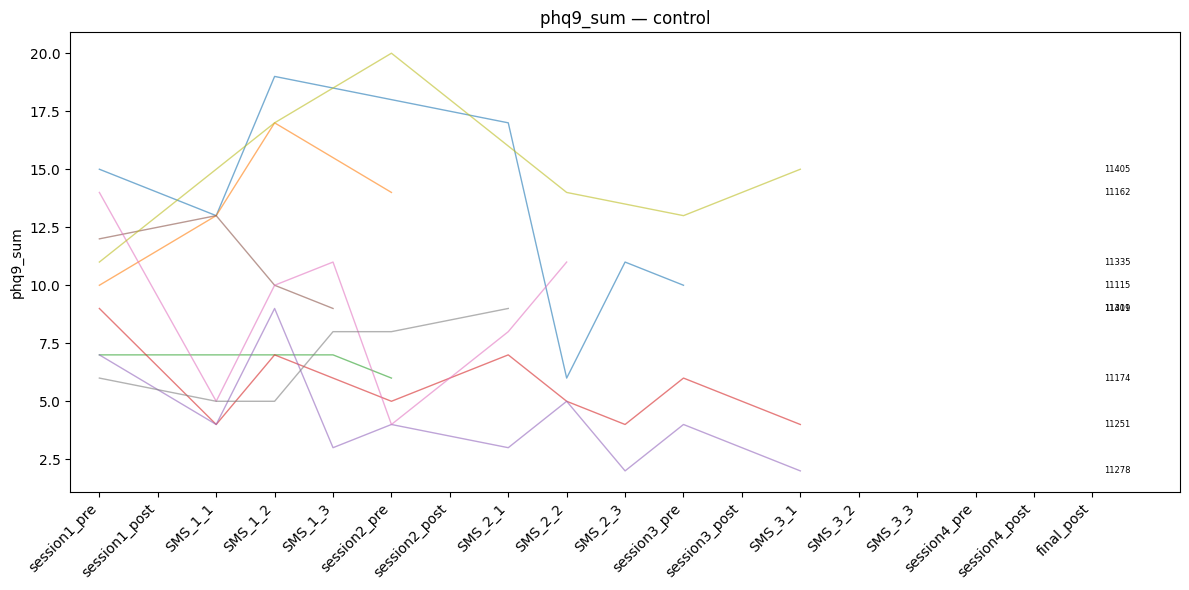

First MCID‐level worsening events (threshold ≥ 5):


part_id timepoint  phq9_sum  change
106   11162   SMS_1_2      17.0     7.0
99    11405   SMS_1_2      17.0     6.0


── phq9_sum  |  Condition: intervention ──


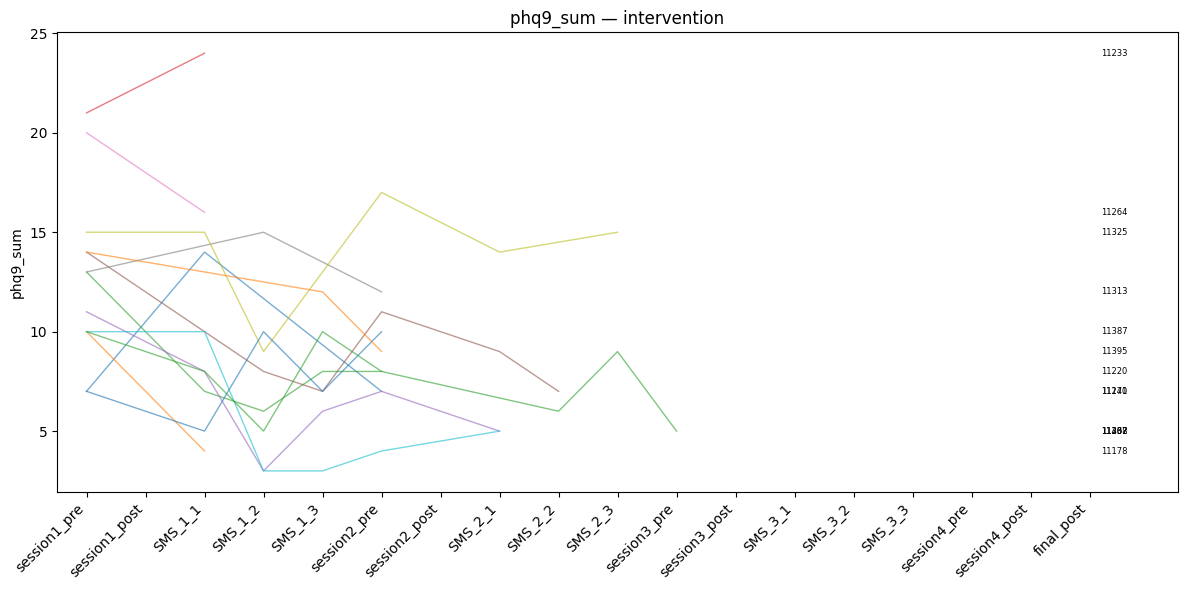

First MCID‐level worsening events (threshold ≥ 5):


part_id timepoint  phq9_sum  change
114   11171   SMS_1_1      14.0     7.0


── spane_p  |  Condition: control ──


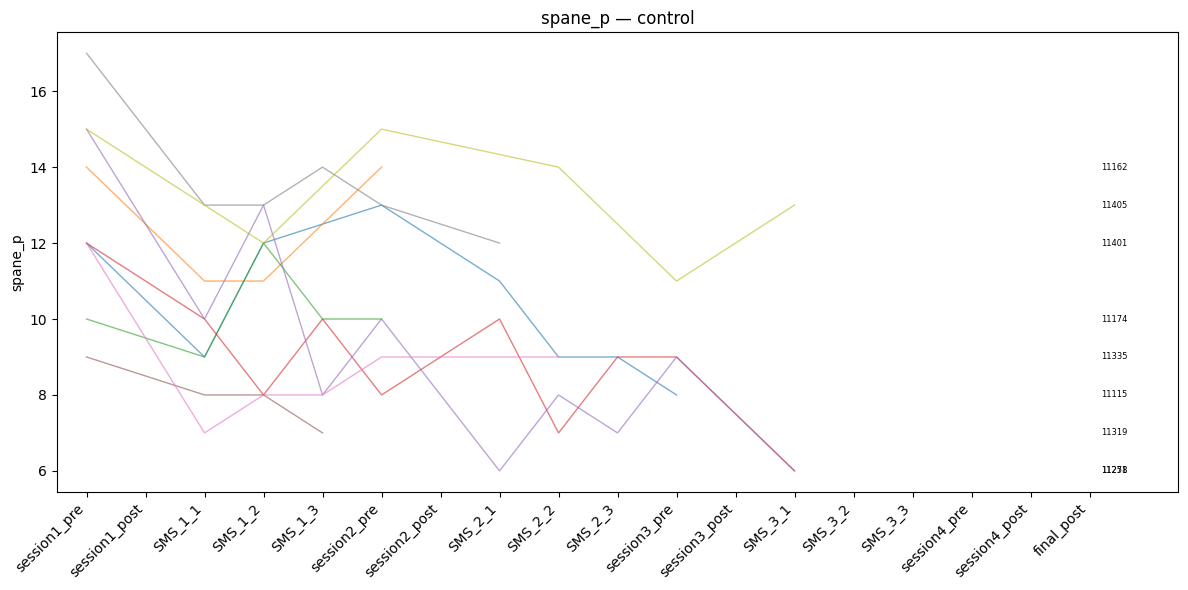

First MCID‐level worsening events (threshold ≥ 2):


part_id timepoint  spane_p  change
95    11115   SMS_1_1      9.0    -3.0
93    11162   SMS_1_1     11.0    -3.0
90    11251   SMS_1_1     10.0    -2.0
91    11278   SMS_1_1     10.0    -5.0
161   11319   SMS_1_3      7.0    -2.0
102   11335   SMS_1_1      7.0    -5.0
101   11401   SMS_1_1     13.0    -4.0
99    11405   SMS_1_2     12.0    -3.0


── spane_p  |  Condition: intervention ──


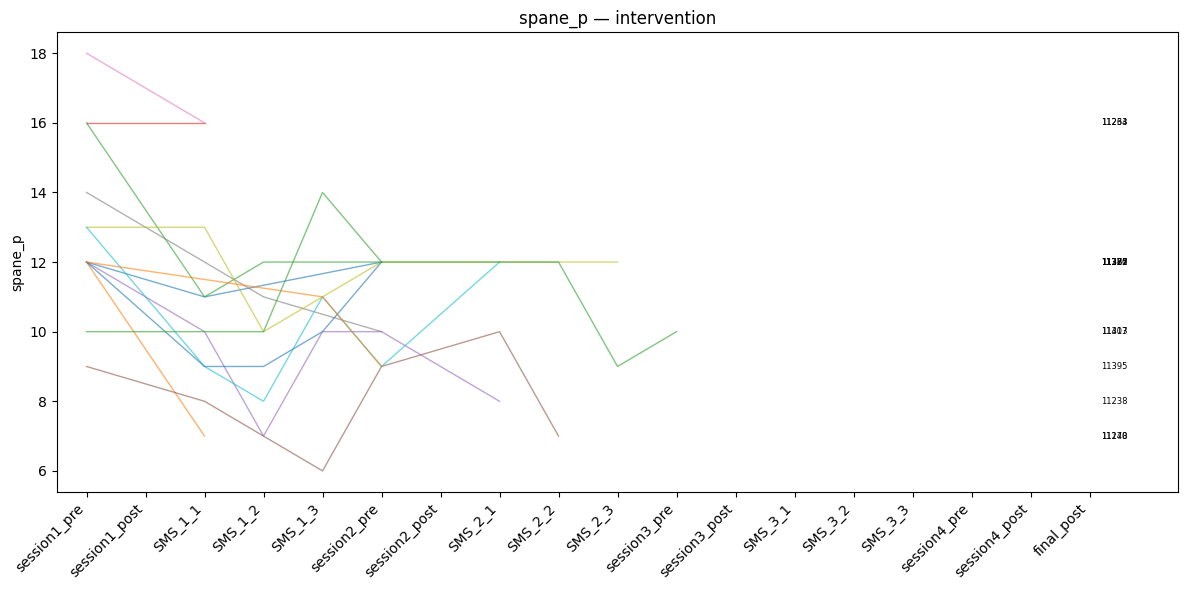

First MCID‐level worsening events (threshold ≥ 2):


part_id     timepoint  spane_p  change
142   11178       SMS_1_1      7.0    -5.0
131   11220       SMS_1_1     11.0    -5.0
121   11238       SMS_1_1     10.0    -2.0
116   11240       SMS_1_2      7.0    -2.0
147   11264       SMS_1_1     16.0    -2.0
134   11313       SMS_1_2     11.0    -3.0
113   11325       SMS_1_2     10.0    -3.0
96    11362       SMS_1_1      9.0    -4.0
115   11387       SMS_1_1      9.0    -3.0
43    11395  session2_pre      9.0    -3.0


── spane_n  |  Condition: control ──


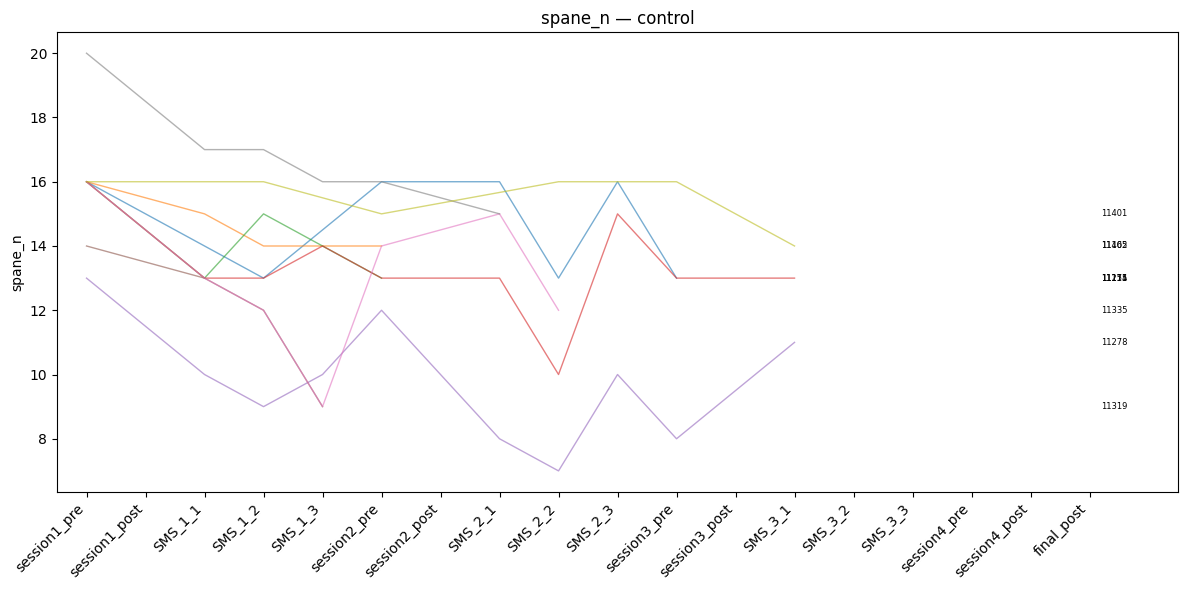

No participants worsened by at least the MCID of 2 for spane_n.

── spane_n  |  Condition: intervention ──


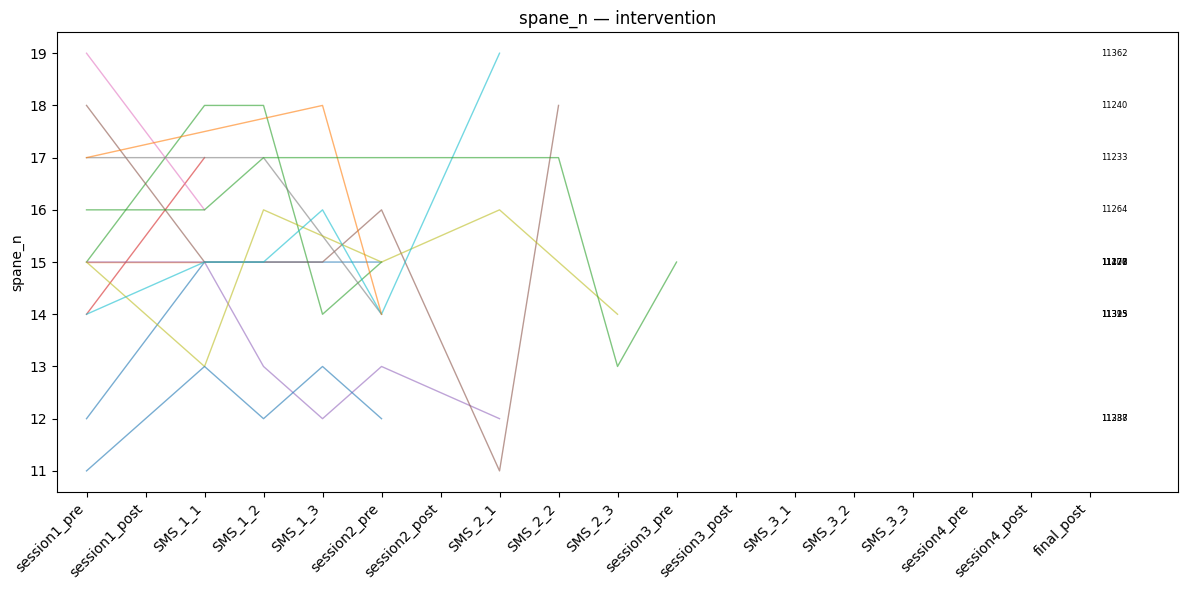

First MCID‐level worsening events (threshold ≥ 2):


part_id timepoint  spane_n  change
114   11171   SMS_1_1     15.0     3.0
131   11220   SMS_1_1     18.0     3.0
154   11233   SMS_1_1     17.0     3.0
123   11362   SMS_1_3     16.0     2.0
115   11387   SMS_1_1     13.0     2.0


── m3vas_mood  |  Condition: control ──


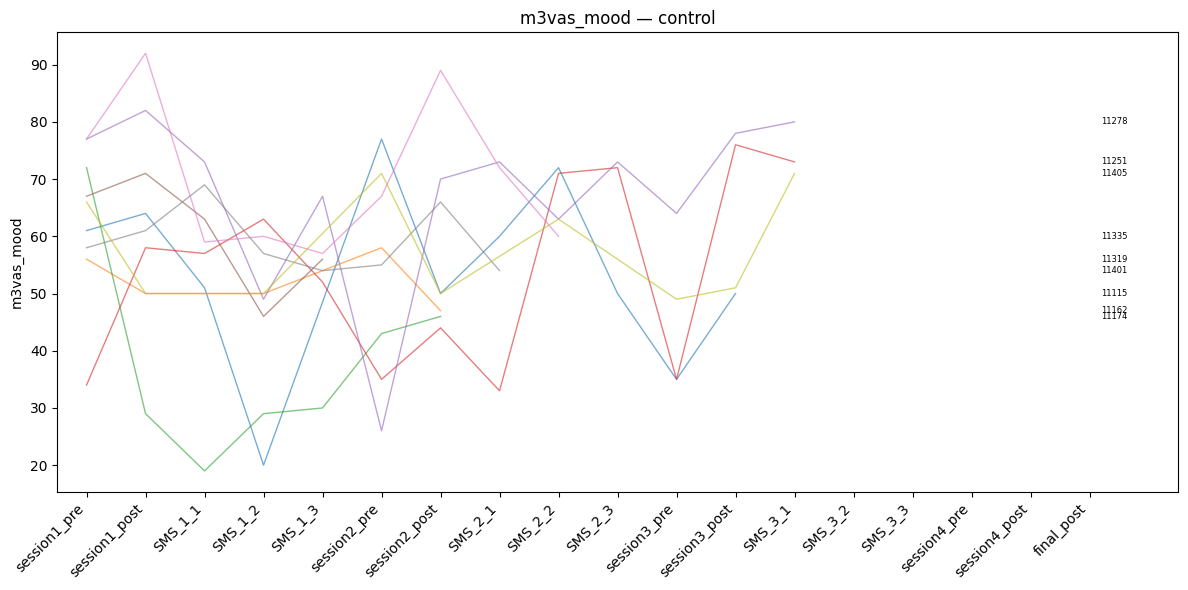

First MCID‐level worsening events (threshold ≥ 12):


part_id      timepoint  m3vas_mood  change
103   11115        SMS_1_2        20.0   -41.0
54    11174  session1_post        29.0   -43.0
100   11278        SMS_1_2        49.0   -28.0
148   11319        SMS_1_2        46.0   -21.0
102   11335        SMS_1_1        59.0   -18.0
47    11405  session1_post        50.0   -16.0


── m3vas_mood  |  Condition: intervention ──


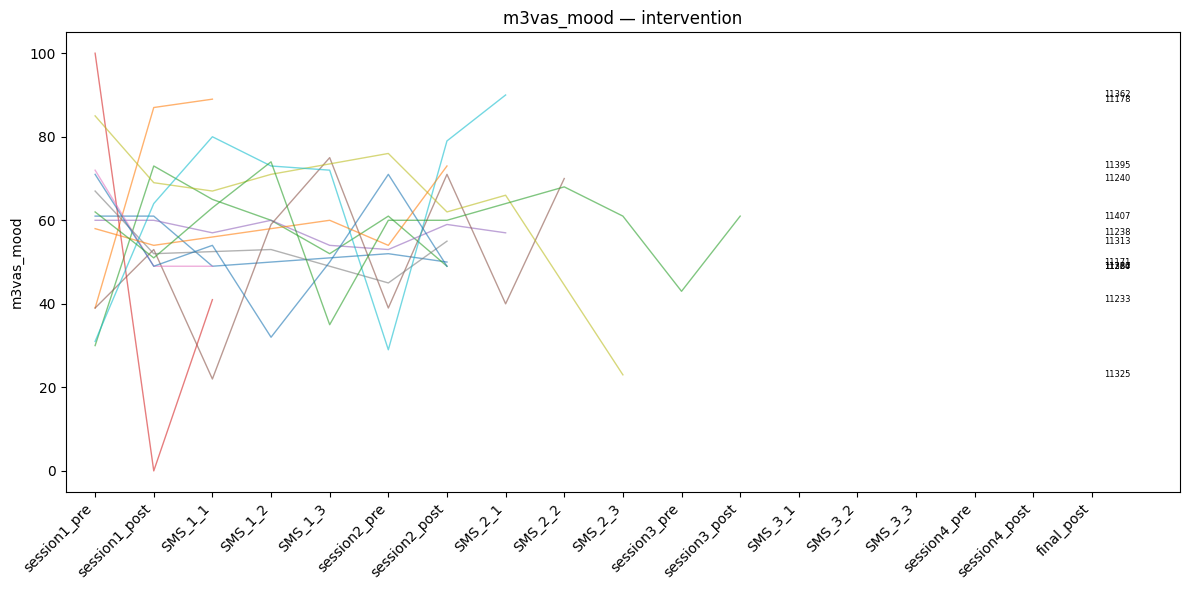

First MCID‐level worsening events (threshold ≥ 12):


part_id      timepoint  m3vas_mood  change
114   11171        SMS_1_1        49.0   -12.0
79    11233  session1_post         0.0  -100.0
108   11240        SMS_1_1        22.0   -17.0
77    11264  session1_post        49.0   -23.0
63    11313  session1_post        52.0   -15.0
53    11325  session1_post        69.0   -16.0
59    11387  session1_post        49.0   -22.0
111   11407        SMS_1_3        35.0   -27.0


── m3vas_pleasure  |  Condition: control ──


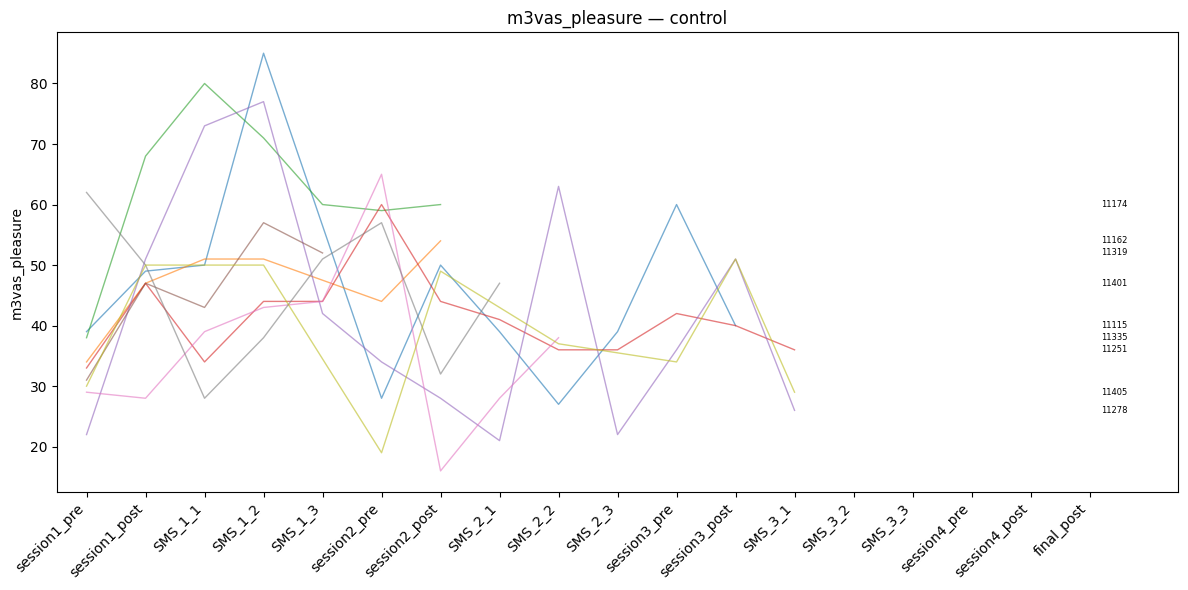

First MCID‐level worsening events (threshold ≥ 12):


part_id      timepoint  m3vas_pleasure  change
136   11115        SMS_2_2            27.0   -12.0
75    11335  session2_post            16.0   -13.0
51    11401  session1_post            50.0   -12.0


── m3vas_pleasure  |  Condition: intervention ──


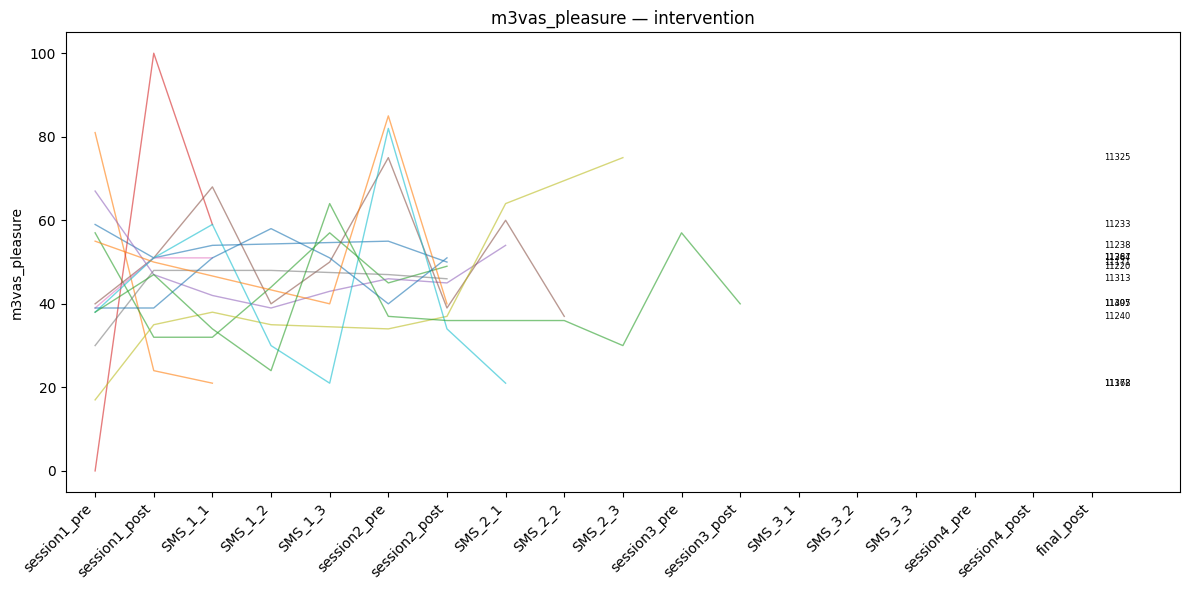

First MCID‐level worsening events (threshold ≥ 12):


part_id      timepoint  m3vas_pleasure  change
76    11178  session1_post            24.0   -57.0
68    11220  session1_post            32.0   -25.0
62    11238  session1_post            47.0   -20.0
123   11362        SMS_1_3            21.0   -17.0
146   11395        SMS_1_3            40.0   -15.0
104   11407        SMS_1_2            24.0   -14.0


── m3vas_suicidal  |  Condition: control ──


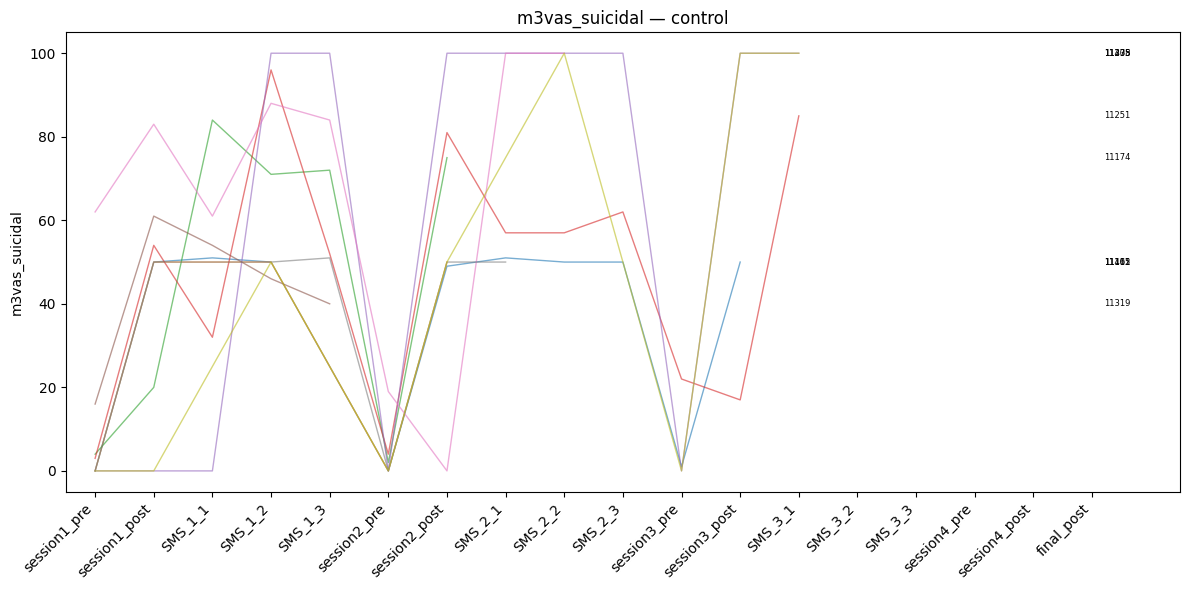

First MCID‐level worsening events (threshold ≥ 12):


part_id      timepoint  m3vas_suicidal  change
49    11115  session1_post            50.0    50.0
50    11162  session1_post            50.0    50.0
54    11174  session1_post            20.0    16.0
45    11251  session1_post            54.0    51.0
100   11278        SMS_1_2           100.0   100.0
73    11319  session1_post            61.0    45.0
55    11335  session1_post            83.0    21.0
51    11401  session1_post            50.0    50.0
99    11405        SMS_1_2            50.0    50.0


── m3vas_suicidal  |  Condition: intervention ──


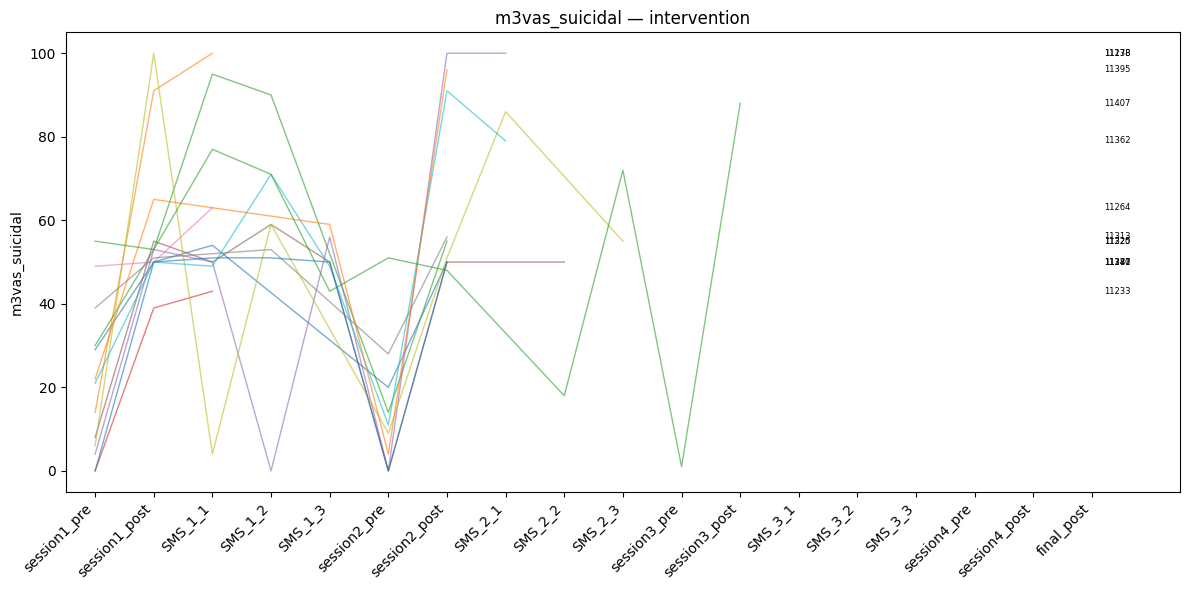

First MCID‐level worsening events (threshold ≥ 12):


part_id      timepoint  m3vas_suicidal  change
57    11171  session1_post            50.0    21.0
76    11178  session1_post            91.0    77.0
68    11220  session1_post            53.0    23.0
79    11233  session1_post            39.0    39.0
62    11238  session1_post            53.0    49.0
56    11240  session1_post            55.0    47.0
147   11264        SMS_1_1            63.0    14.0
63    11313  session1_post            51.0    12.0
53    11325  session1_post           100.0    94.0
52    11362  session1_post            50.0    29.0
59    11387  session1_post            50.0    50.0
67    11395  session1_post            65.0    43.0
92    11407        SMS_1_1            77.0    22.0


── fisber_1  |  Condition: control ──


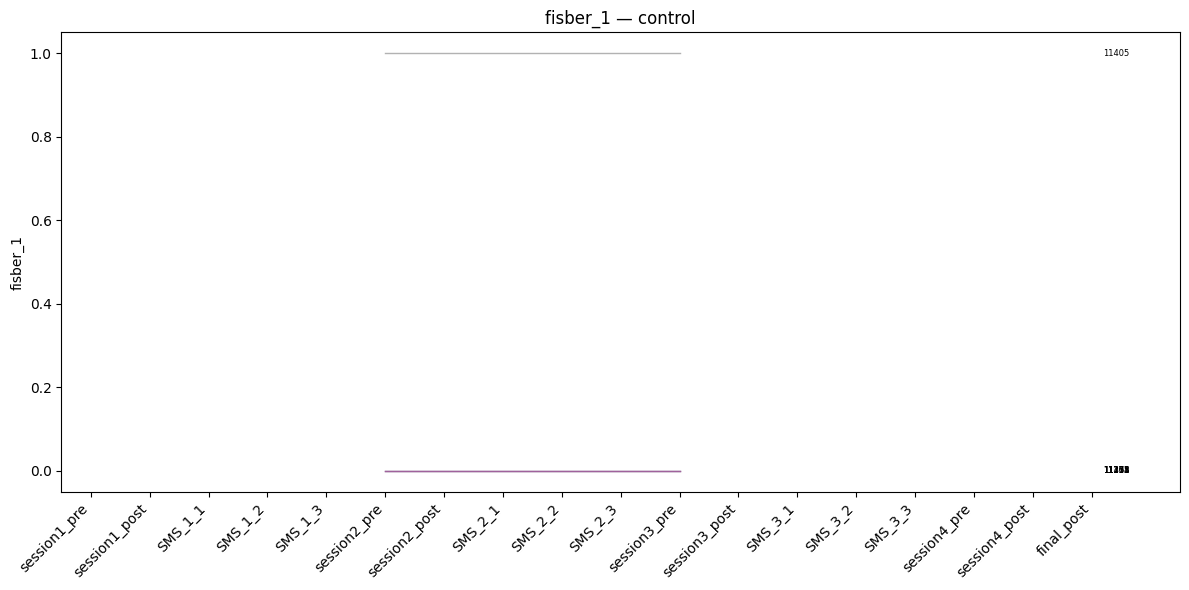

No worsening in this condition.

── fisber_1  |  Condition: intervention ──


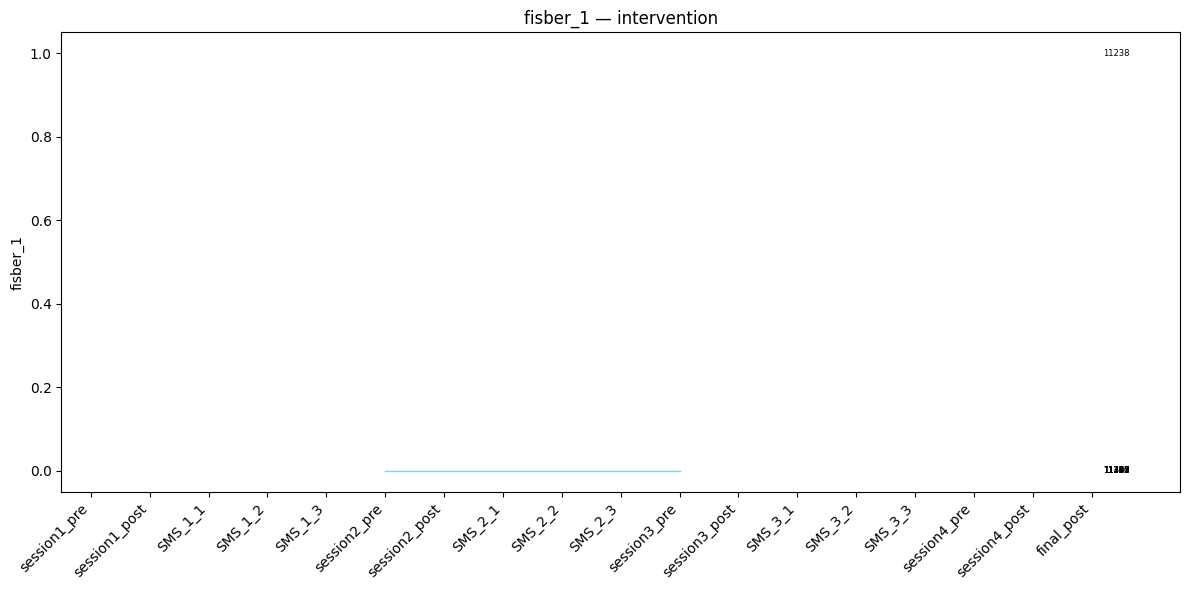

No worsening in this condition.

── fisber_2  |  Condition: control ──


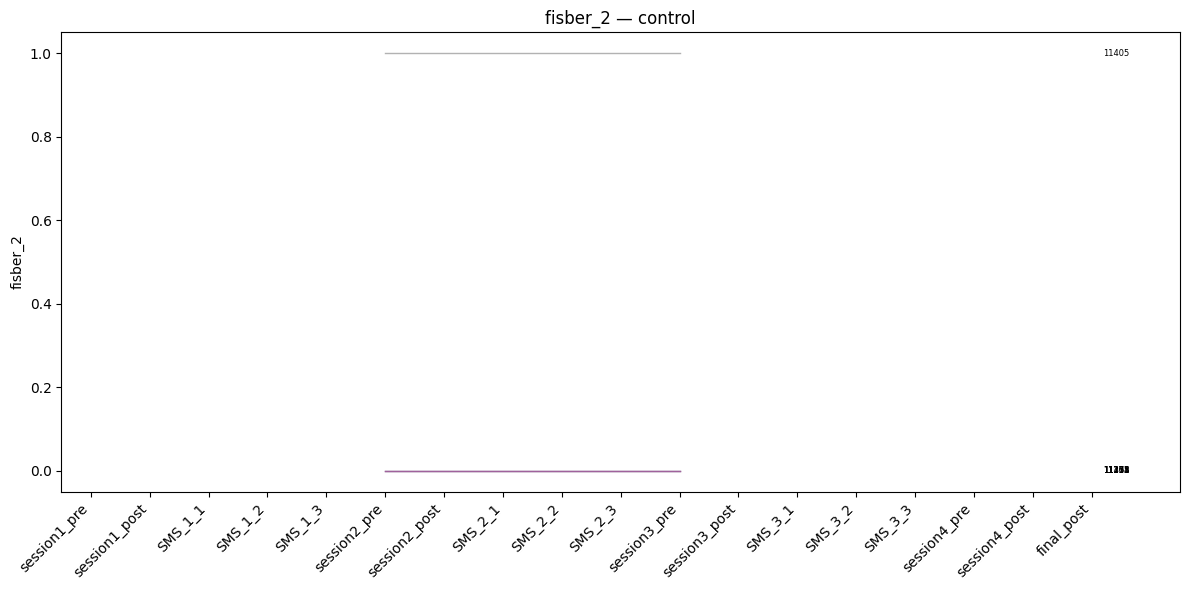

No worsening in this condition.

── fisber_2  |  Condition: intervention ──


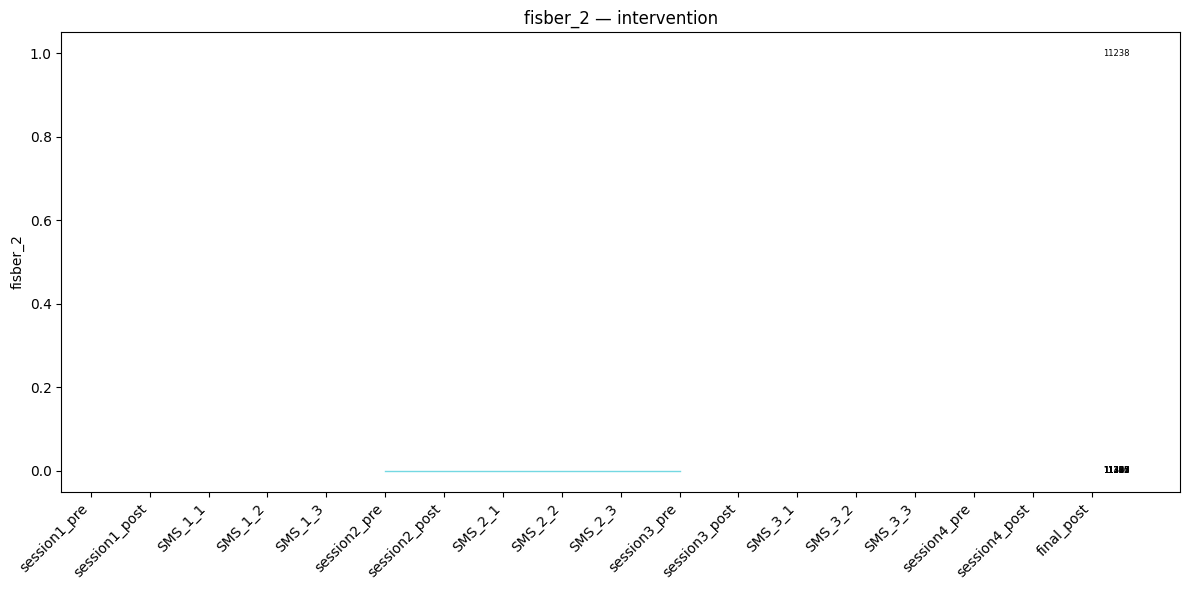

No worsening in this condition.

── fisber_3  |  Condition: control ──


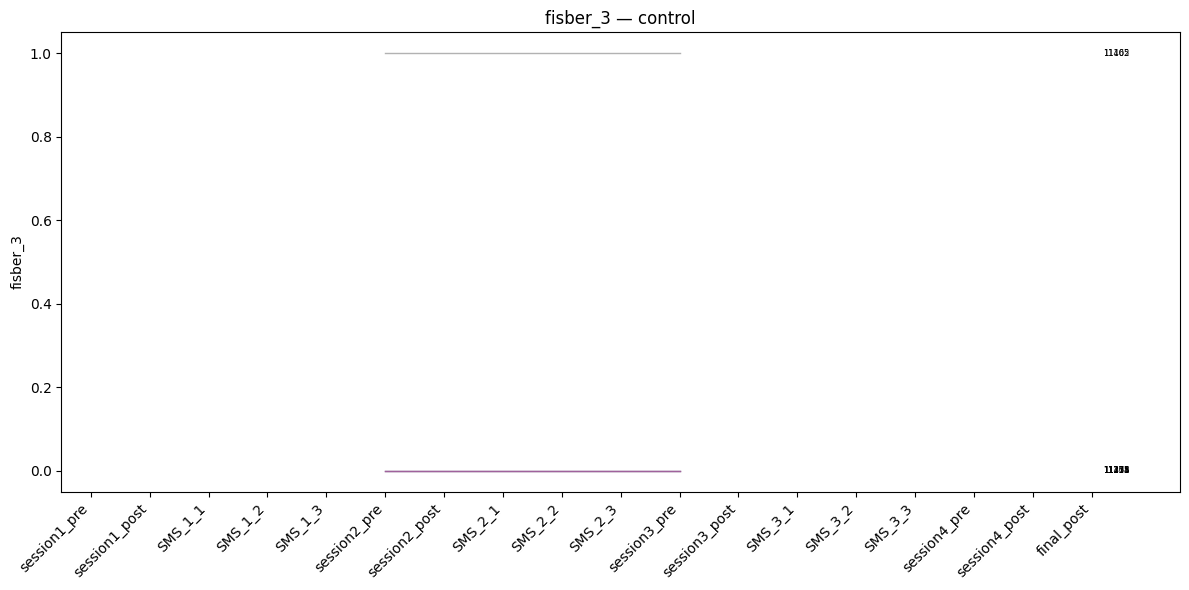

No worsening in this condition.

── fisber_3  |  Condition: intervention ──


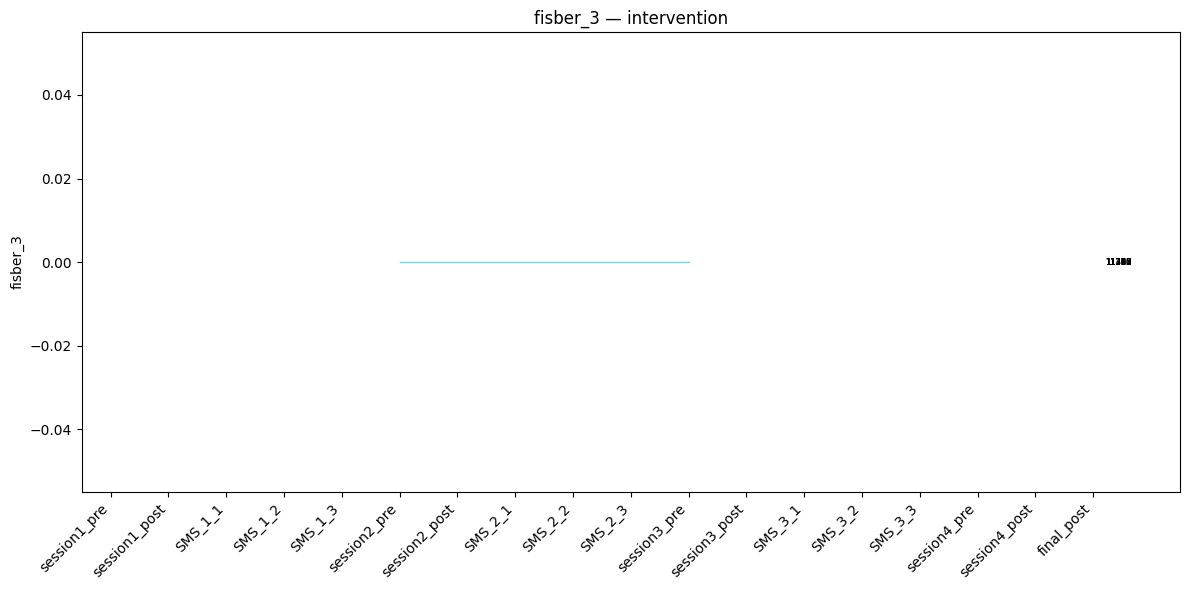

No worsening in this condition.

── bai_sum  |  Condition: control ──


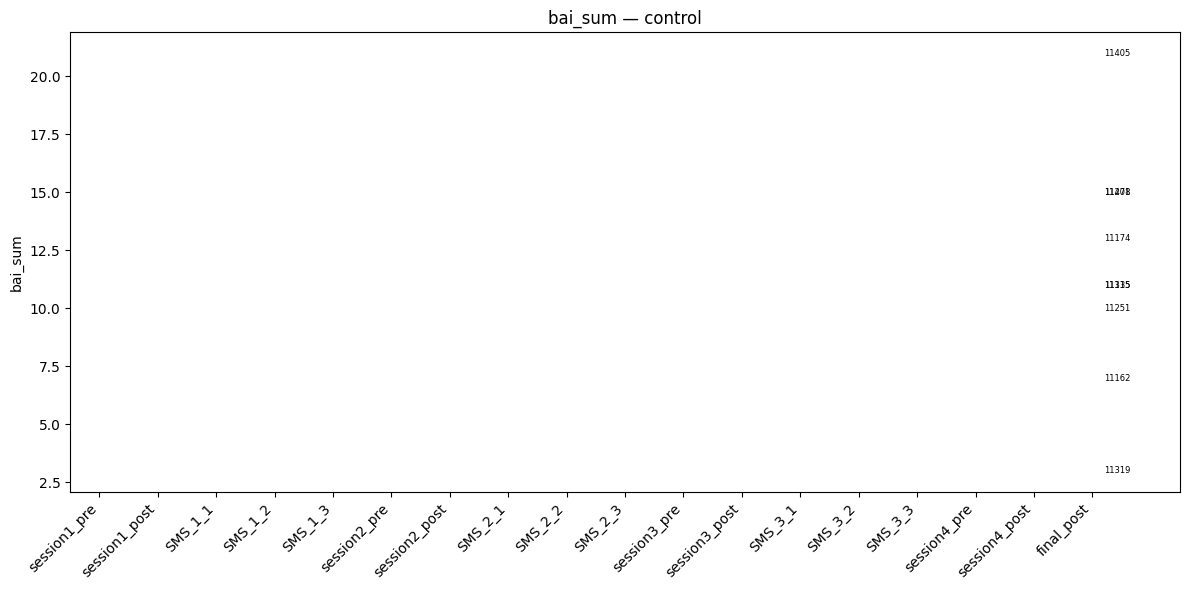

No worsening in this condition.

── bai_sum  |  Condition: intervention ──


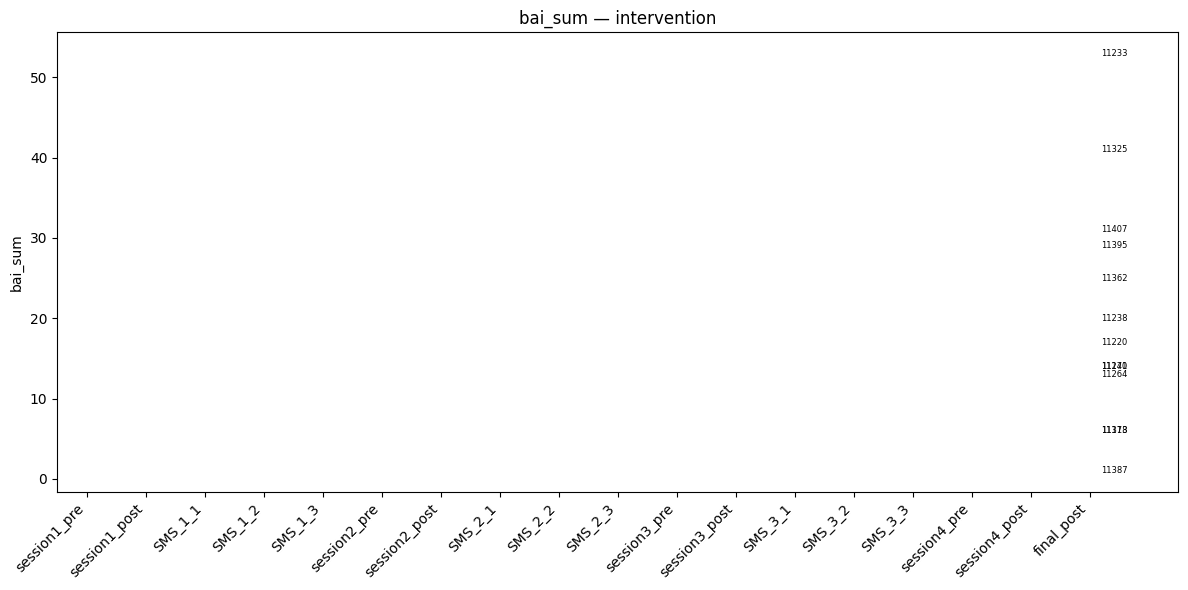

No worsening in this condition.

── bdi_sum  |  Condition: control ──


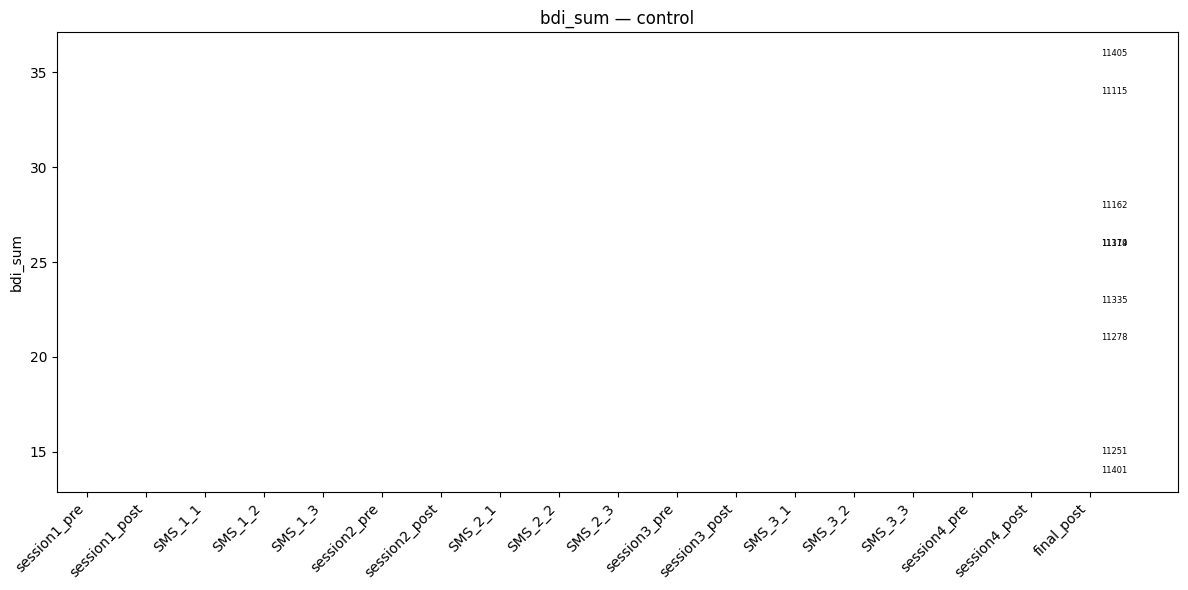

No worsening in this condition.

── bdi_sum  |  Condition: intervention ──


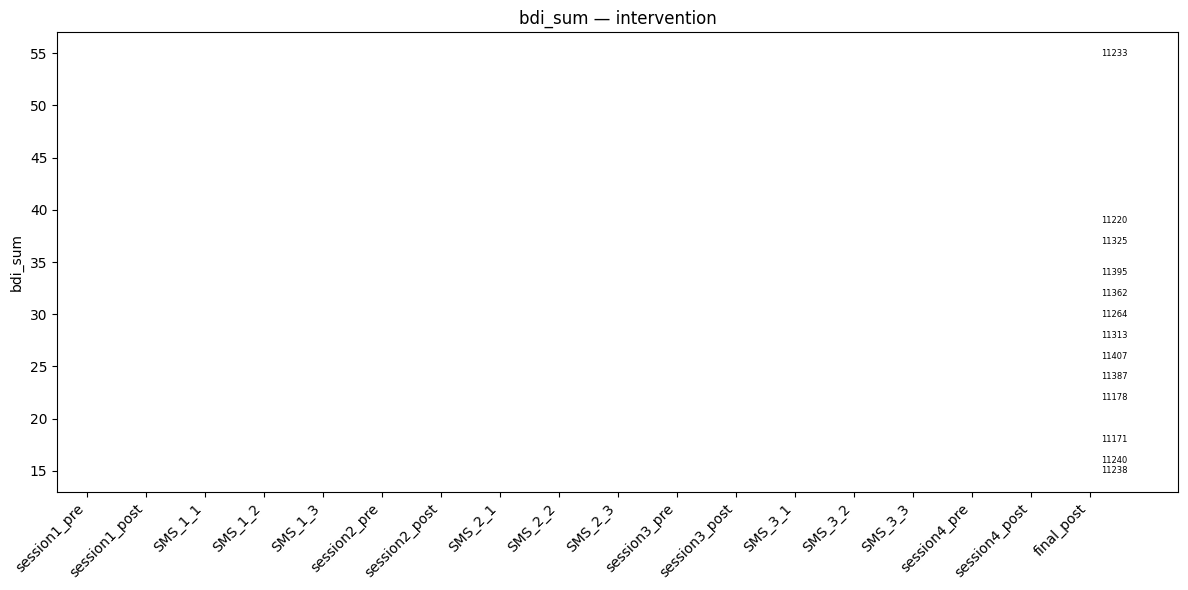

No worsening in this condition.

── MADRS_S_sum  |  Condition: control ──


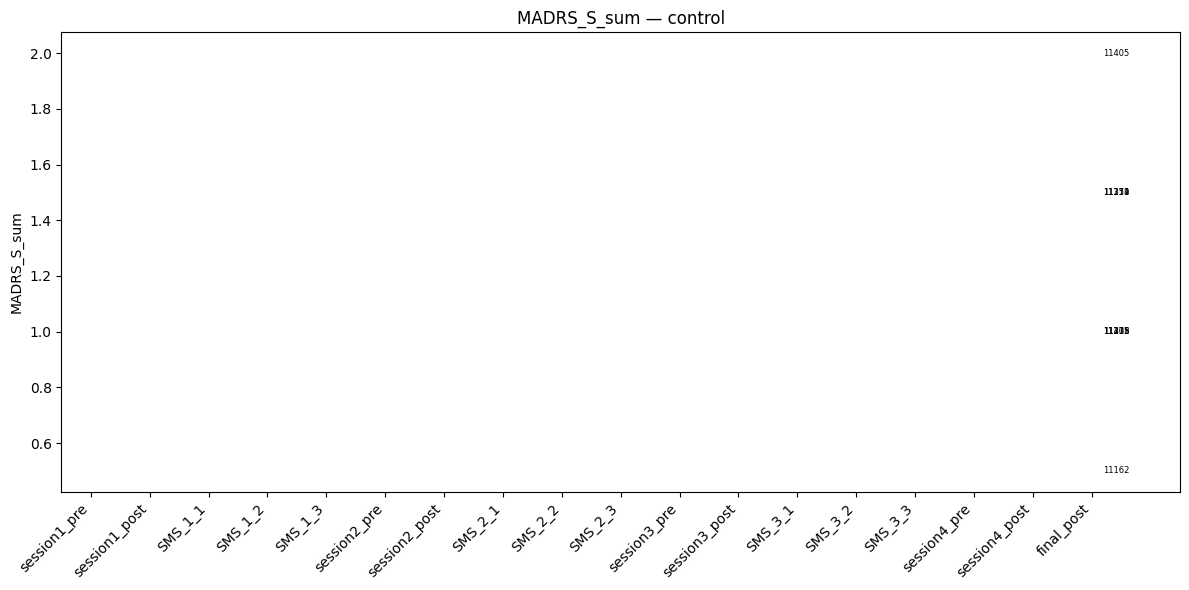

No worsening in this condition.

── MADRS_S_sum  |  Condition: intervention ──


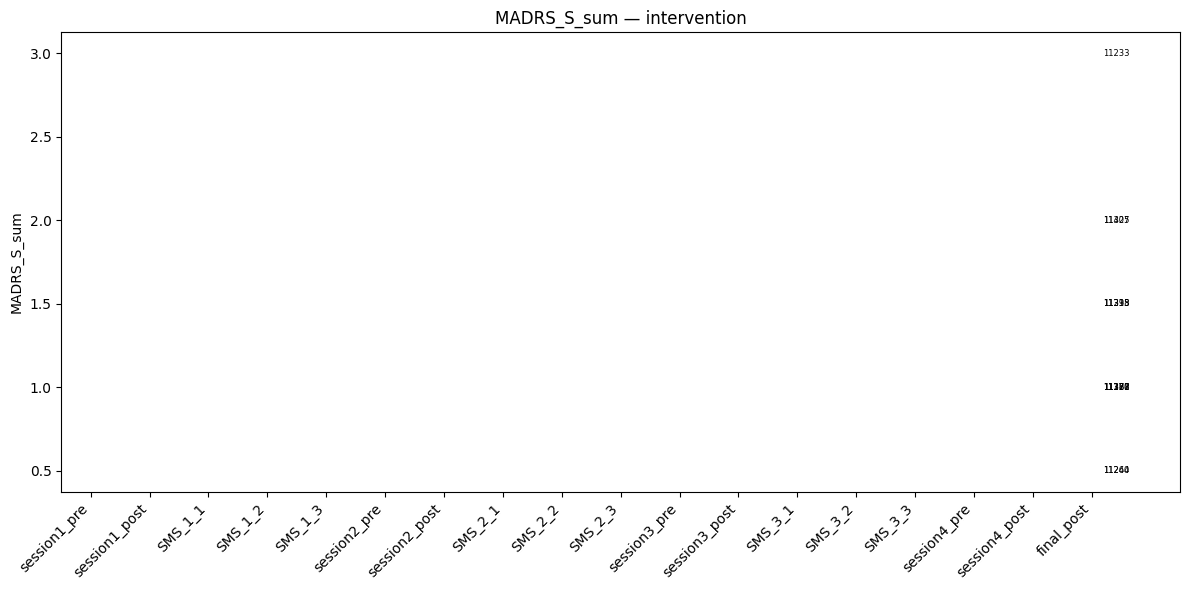

No worsening in this condition.


In [6]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#####
# 0) SETTINGS
#####
DATA_DIR = Path('/content')

#####
# 1) UTILITY TO FIND EXACTLY ONE CSV
#####
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 1b) TRY TO LOAD A CSV, BUT SKIP IF MISSING OR AMBIGUOUS
#####
def try_load(substring: str) -> pd.DataFrame | None:
    try:
        path = find_csv(substring)
    except (FileNotFoundError, ValueError) as e:
        print(f"Skipping '{substring}': {e}")
        return None
    print(f"Loaded '{substring}' from {path.name}")
    return pd.read_csv(path, dtype=str)

#####
# 2) LOAD ALL WELLBEING CSVS (skipping any that aren’t there yet)
#####
df_s1_pre     = try_load('pre_session_1')
df_s2to4_pre  = try_load('pre_sessions_2-4')
df_s2to4_post = try_load('post_sessions_1-3')
df_s4_post    = try_load('post_session_4')
df_sms        = try_load('sms_day1,3,5')
df_final      = try_load('sms_post')

# Collect only the ones that actually loaded
all_dfs = [df for df in (
    df_s1_pre,
    df_s2to4_pre,
    df_s2to4_post,
    df_s4_post,
    df_sms,
    df_final
) if df is not None]

if not all_dfs:
    raise RuntimeError("No data files found to process!")

#####
# 3) CLEAN BDI ITEMS (extract leading number)
#####
for df in all_dfs:
    bdi_raw = [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]
    for col in bdi_raw:
        df[col] = (
            df[col].astype(str)
                  .str.extract(r'^(\d+)')[0]
                  .astype(float)
        )

#####
# 4) SUM SCALES
#####
def sum_scale(df, cols, new_col):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[new_col] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

for df in all_dfs:
    # BAI
    bai_cols = get_scale_cols(df, 'bai', 21)
    if bai_cols:
        sum_scale(df, bai_cols, 'bai_sum')
    # BDI
    bdi_cols = get_scale_cols(df, 'bdi', 21)
    if bdi_cols:
        sum_scale(df, bdi_cols, 'bdi_sum')
    # MADRS
    madrs_cols = get_scale_cols(df, 'madrs', 9, allow_suffix=True)
    if madrs_cols:
        sum_scale(df, madrs_cols, 'MADRS_S_sum')

#####
# 5) STANDARDIZE M3VAS
#####
def standardize_m3vas(df):
    for var in ('mood','pleasure','suicidal'):
        ch_cols  = [c for c in df.columns if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)]
        raw_cols = [c for c in df.columns if re.fullmatch(f"m3vas_{var}(?:_1)?",    c)]
        if ch_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[ch_cols[0]], errors='coerce') + 50
        elif raw_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[raw_cols[0]], errors='coerce')
    # invert pleasure
    if 'm3vas_pleasure' in df.columns:
        df['m3vas_pleasure'] = 100 - df['m3vas_pleasure']
    # drop raw/input cols
    drop_pattern = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_pattern.match(c)]
    if to_drop:
        df.drop(columns=to_drop, inplace=True)

for df in all_dfs:
    standardize_m3vas(df)

#####
# 6) CLEAN FISBER
#####
for df in all_dfs:
    for col in ('fisber_1','fisber_2','fisber_3'):
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                       .str.extract(r'(\d+)$')[0]
                       .astype(float)
            )

#####
# 7) COERCE TYPES
#####
# session_n for sessions
for df in (df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post):
    if df is not None and 'session_n' in df.columns:
        df['session_n'] = pd.to_numeric(df['session_n'], errors='coerce').astype('Int64')

# session_n & sms_n for SMS
if df_sms is not None:
    for col in ('session_n','sms_n'):
        if col in df_sms.columns:
            df_sms[col] = pd.to_numeric(df_sms[col], errors='coerce').astype('Int64')

# numeric scales
numeric_cols = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for df in all_dfs:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# 8) ENSURE EVERY DF HAS part_id
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)
    df['part_id'] = df['part_id'].astype(str).str.strip()

#####
# 9) TAG TIMEPOINTS
#####
if df_s1_pre    is not None: df_s1_pre    ['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None: df_s2to4_pre ['timepoint'] = df_s2to4_pre.apply(lambda r: f"session{r.session_n}_pre",  axis=1)
if df_s2to4_post is not None: df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
if df_s4_post   is not None: df_s4_post   ['timepoint'] = 'session4_post'
if df_sms       is not None: df_sms       ['timepoint'] = df_sms.apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
if df_final     is not None: df_final     ['timepoint'] = 'final_post'

#####
# 10) CONCATENATE
#####
df_long = pd.concat(all_dfs, ignore_index=True)

#####
# 11) DROP NON-NUMERIC part_id
#####
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

#####
# 12) MERGE IN CONDITION (if assignments file was found)
#####
df_assign = try_load('wp2_assignments')
if df_assign is not None:
    df_long = df_long.merge(
        df_assign[['part_id','condition']],
        on='part_id',
        how='inner'
    )
else:
    print("No assignments file: skipping merge with 'condition' column")

#####
# 13) DEFINE & APPLY ORDERED CATEGORICAL FOR timepoint
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)

#####
# 14) PLOTTING + FLAGGING BY CONDITION
#####
bad_if_higher = {
    'phq9_sum',
    'spane_n',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum',
    'm3vas_suicidal'   # higher = more suicidal = worse
}

bad_if_lower = {
    'spane_p',
    'm3vas_mood',      # higher = better mood, so a drop is worsening
    'm3vas_pleasure'   # higher = better pleasure, so a drop is worsening
}

mcid_thresholds = {
    'phq9_sum': 5,
    'spane_p': 2,
    'spane_n': 2,
    'm3vas_mood': 12,
    'm3vas_pleasure': 12,
    'm3vas_suicidal': 12
}

#####
# ADJUST M3VAS SO 50 → 0 (“no change”), 0 → –50 (worse), 100 → +50 (better)
#####
def standardize_m3vas(df):
    to_drop = []
    for var in ('suicidal','mood','pleasure'):
        # find change‐score first, then raw‐score
        ch_col  = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_ch_{var}(?:_1)?", c)), None)
        raw_col = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_{var}(?:_1)?",    c)), None)

        if ch_col:
            vals = pd.to_numeric(df[ch_col], errors='coerce') - 50
            to_drop.append(ch_col)
        elif raw_col:
            vals = pd.to_numeric(df[raw_col], errors='coerce') - 50
            to_drop.append(raw_col)
        else:
            continue

        if var == 'suicidal':
            # leave as-is: + means more suicidal (worse), so improvement → down
            df[f"m3vas_{var}"] = vals
        else:
            # mood & pleasure: + means improvement, so flip sign
            df[f"m3vas_{var}"] = -vals

    # drop only the original raw/change columns
    df.drop(columns=to_drop, inplace=True, errors='ignore')

# apply to each dataframe
for df in all_dfs:
    standardize_m3vas(df)

def plot_and_flag_by_condition(measure):
    if measure not in df_long.columns:
        print(f"→ skipping '{measure}': not in df_long")
        return

    # For these measures, remove any session*_post timepoints
    df_plot = df_long.copy()
    if measure in ('phq9_sum','spane_p','spane_n'):
        df_plot = df_plot[~df_plot['timepoint'].str.match(r'^session\d+_post$')]

    for cond, dfc in df_plot.groupby('condition', dropna=False):
        print(f"\n── {measure}  |  Condition: {cond} ──")
        fig, ax = plt.subplots(figsize=(12,6))
        x_final = len(ordered_timepoints) - 1

        # Plot trajectories
        for pid, grp in dfc.groupby('part_id'):
            s = grp.dropna(subset=['timepoint', measure]).sort_values('timepoint')
            if s.empty:
                continue
            x = s['timepoint'].cat.codes
            y = s[measure].astype(float)
            ax.plot(x, y, linewidth=1, alpha=0.6)
            ax.text(x_final+0.2, y.iloc[-1], pid, fontsize=6, va='center')

        ax.set_xlim(-0.5, x_final+1.5)
        ax.set_xticks(range(len(ordered_timepoints)))
        ax.set_xticklabels(ordered_timepoints, rotation=45, ha='right')
        ax.set_ylabel(measure)
        ax.set_title(f"{measure} — {cond}")
        plt.tight_layout(); plt.show()

        # Flag first MCID‐level worsening events
        if measure in mcid_thresholds:
            th = mcid_thresholds[measure]
            breach_events = []
            for pid, grp_pid in dfc.groupby('part_id'):
                seq = (
                    grp_pid
                    .dropna(subset=['timepoint', measure])
                    .sort_values('timepoint')
                    .loc[:, ['part_id','timepoint', measure]]
                    .assign(change=lambda d: d[measure] - d[measure].iloc[0])
                )
                mask = seq['change'] >= th if measure in bad_if_higher else seq['change'] <= -th
                if mask.any():
                    breach_events.append(seq[mask].iloc[0])
            if breach_events:
                print(f"First MCID‐level worsening events (threshold ≥ {th}):")
                display(pd.DataFrame(breach_events))
            else:
                print(f"No participants worsened by at least the MCID of {th} for {measure}.")
        else:
            # fallback: ever‐worsened
            worsened = []
            for pid, grp_pid in dfc.groupby('part_id'):
                seq = grp_pid.dropna(subset=['timepoint', measure])\
                            .sort_values('timepoint')[measure].astype(float)
                if len(seq)<2: continue
                if ((measure in bad_if_higher and seq.iloc[-1]>seq.iloc[0]) or
                    (measure in bad_if_lower  and seq.iloc[-1]<seq.iloc[0])):
                    worsened.append(pid)
            if worsened:
                print("Worsened trajectories:")
                display(
                    dfc[dfc['part_id'].isin(worsened)]
                       [['part_id','timepoint',measure]]
                       .dropna(subset=[measure])
                       .sort_values(['part_id','timepoint'])
                       .reset_index(drop=True)
                )
            else:
                print("No worsening in this condition.")

# RUN PLOTS FOR ALL MEASURES
measures = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for m in measures:
    plot_and_flag_by_condition(m)

CONDITION-BLIND WELLBEING MONITORING

Loaded 'pre_session_1' from wp2_pre_session_1_July 2, 2025_09.36.csv
Loaded 'pre_sessions_2-4' from wp2_pre_sessions_2-4_July 2, 2025_09.36.csv
Loaded 'post_sessions_1-3' from wp2_post_sessions_1-3_July 2, 2025_09.35.csv
Skipping 'post_session_4': No file matching 'post_session_4' in /content
Loaded 'sms_day1,3,5' from wp2_sms_day1,3,5_July 2, 2025_09.36.csv
Skipping 'sms_post': No file matching 'sms_post' in /content
Loaded 'wp2_assignments' from wp2_assignments.csv


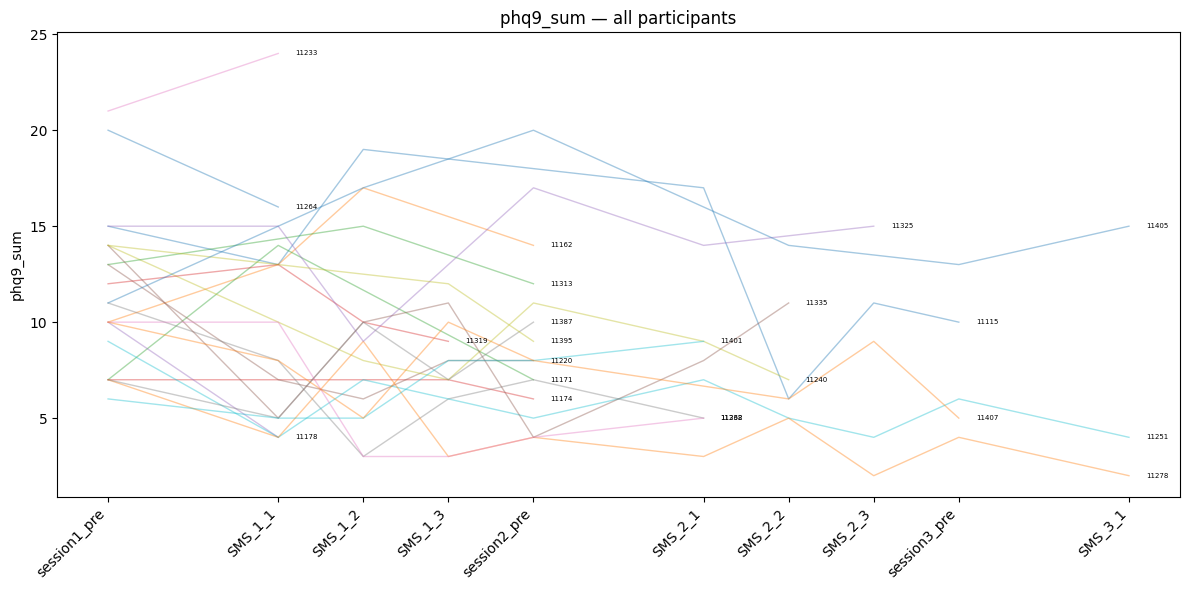

First MCID‐level worsening events (threshold ≥ 5):


part_id timepoint  phq9_sum  change
106   11162   SMS_1_2      17.0     7.0
114   11171   SMS_1_1      14.0     7.0
99    11405   SMS_1_2      17.0     6.0

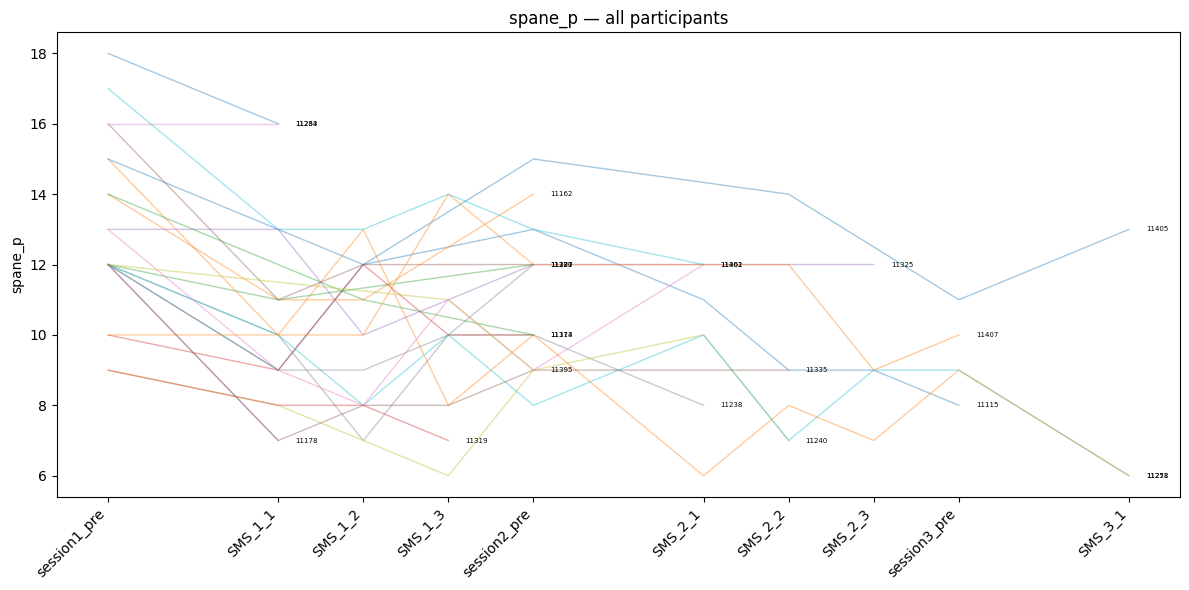

First MCID‐level worsening events (threshold ≥ 2):


part_id     timepoint  spane_p  change
95    11115       SMS_1_1      9.0    -3.0
93    11162       SMS_1_1     11.0    -3.0
142   11178       SMS_1_1      7.0    -5.0
131   11220       SMS_1_1     11.0    -5.0
121   11238       SMS_1_1     10.0    -2.0
116   11240       SMS_1_2      7.0    -2.0
90    11251       SMS_1_1     10.0    -2.0
147   11264       SMS_1_1     16.0    -2.0
91    11278       SMS_1_1     10.0    -5.0
134   11313       SMS_1_2     11.0    -3.0
161   11319       SMS_1_3      7.0    -2.0
113   11325       SMS_1_2     10.0    -3.0
102   11335       SMS_1_1      7.0    -5.0
96    11362       SMS_1_1      9.0    -4.0
115   11387       SMS_1_1      9.0    -3.0
43    11395  session2_pre      9.0    -3.0
101   11401       SMS_1_1     13.0    -4.0
99    11405       SMS_1_2     12.0    -3.0

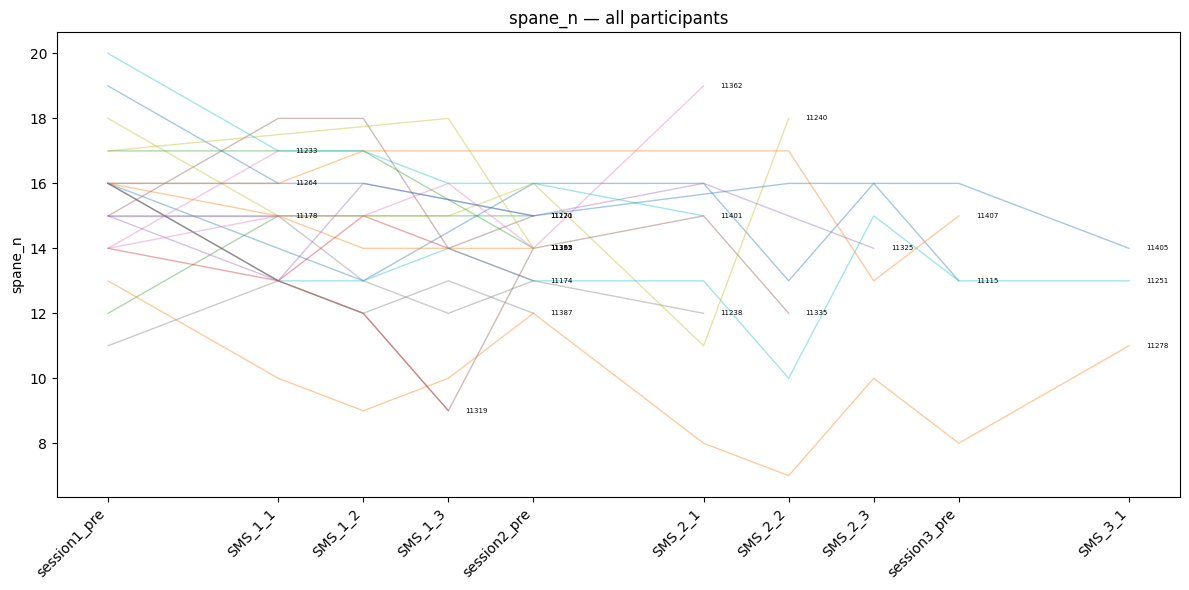

First MCID‐level worsening events (threshold ≥ 2):


part_id timepoint  spane_n  change
114   11171   SMS_1_1     15.0     3.0
131   11220   SMS_1_1     18.0     3.0
154   11233   SMS_1_1     17.0     3.0
123   11362   SMS_1_3     16.0     2.0
115   11387   SMS_1_1     13.0     2.0

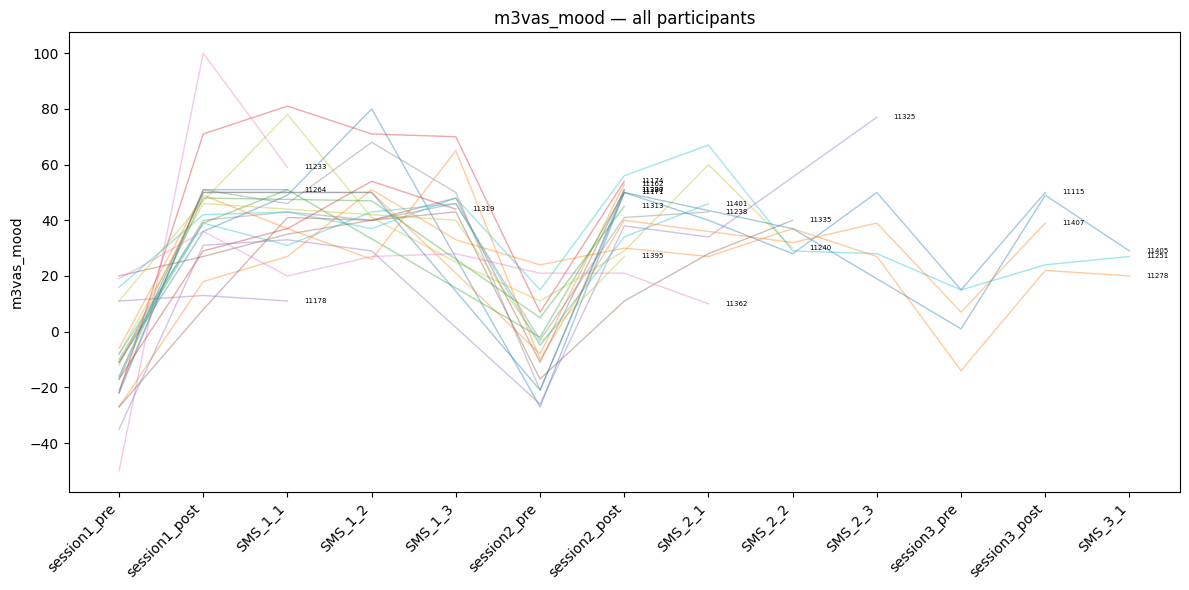

First MCID‐level worsening events (threshold ≥ 12):


part_id     timepoint  m3vas_mood  change
26   11115  session2_pre       -27.0   -16.0
44   11220  session2_pre       -11.0   -31.0

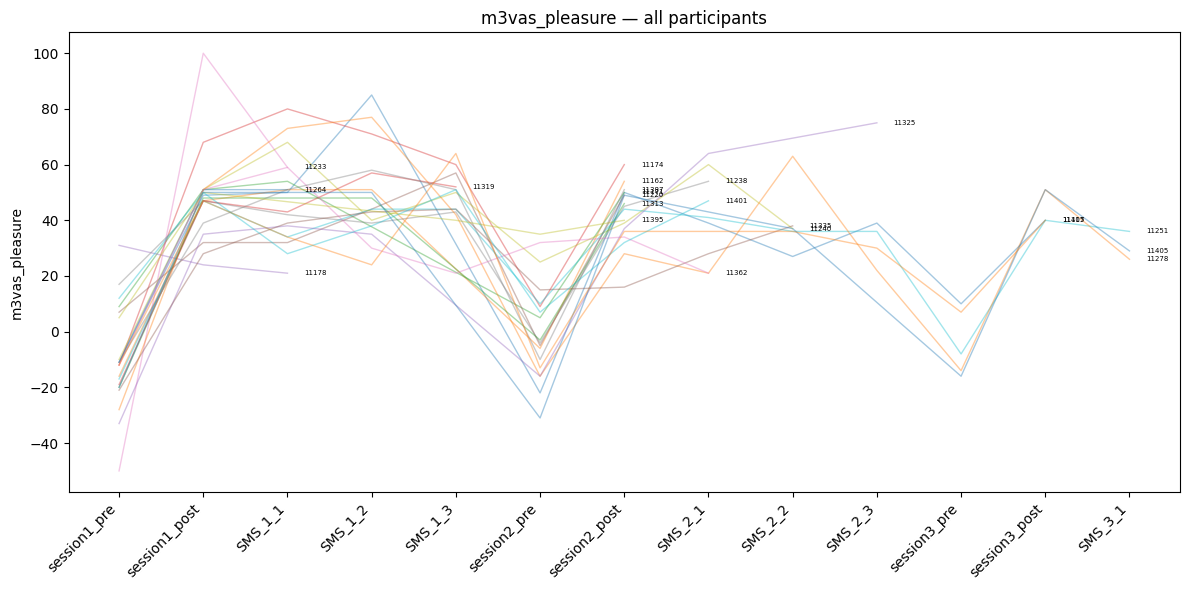

First MCID‐level worsening events (threshold ≥ 12):


part_id     timepoint  m3vas_pleasure  change
44   11220  session2_pre            -5.0   -12.0
38   11238  session2_pre            -4.0   -21.0

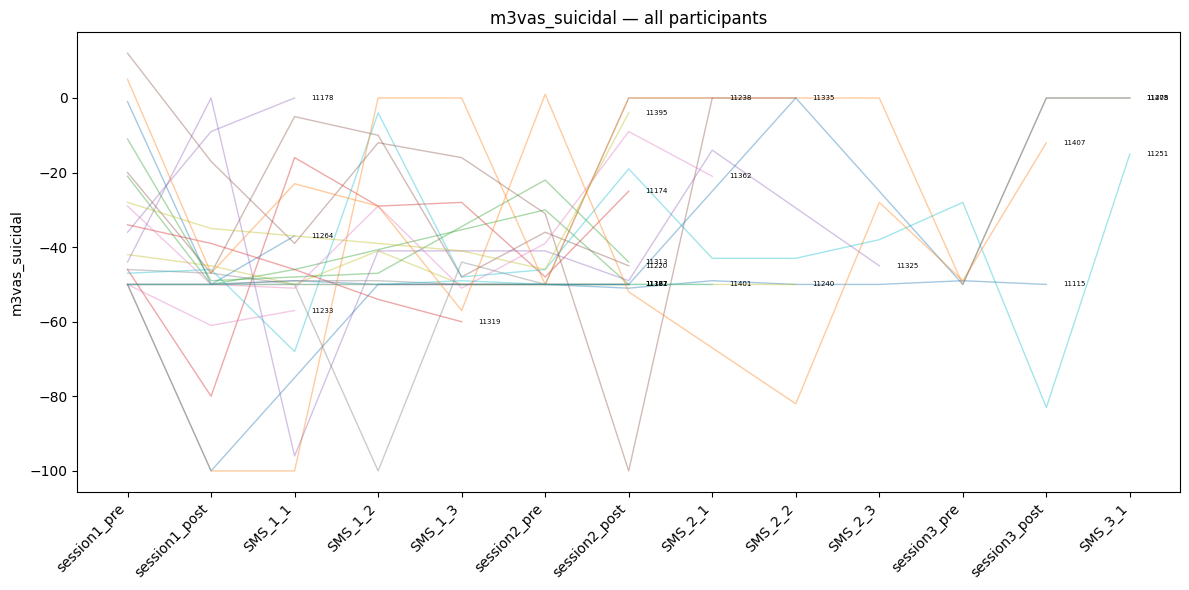

First MCID‐level worsening events (threshold ≥ 12):


part_id      timepoint  m3vas_suicidal  change
97    11174        SMS_1_1           -16.0    30.0
76    11178  session1_post            -9.0    27.0
131   11220        SMS_1_1            -5.0    15.0
83    11238  session2_post             0.0    46.0
94    11251        SMS_1_2            -4.0    43.0
100   11278        SMS_1_2             0.0    50.0
53    11325  session1_post             0.0    44.0
69    11362  session2_post            -9.0    20.0
88    11395  session2_post            -4.0    24.0
132   11405        SMS_2_2             0.0    50.0

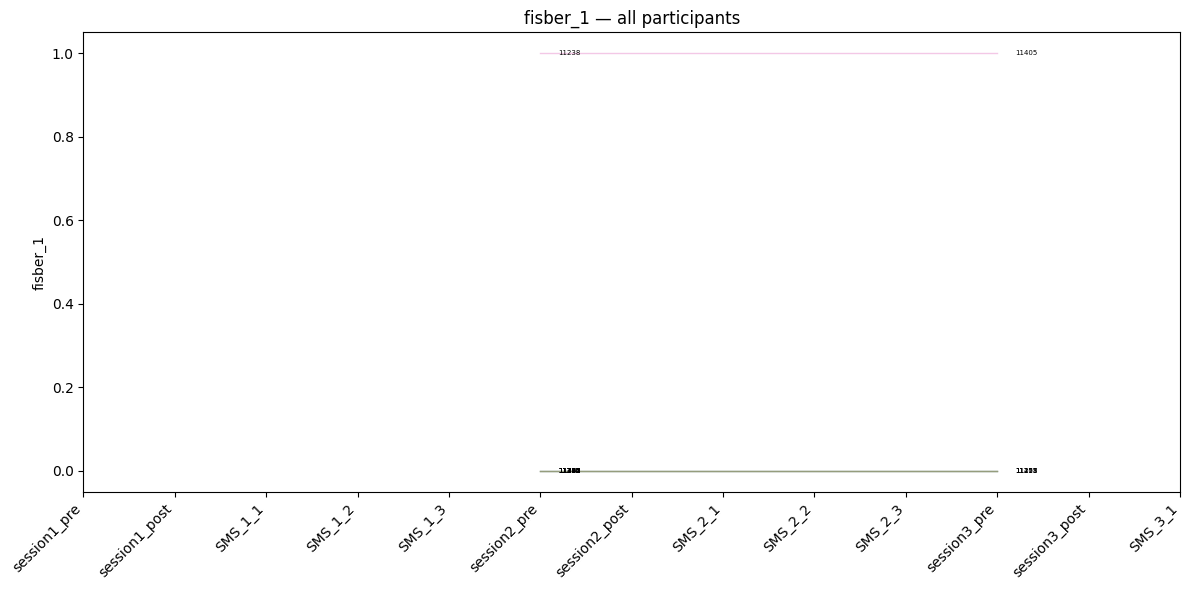

No worsening detected across the sample.


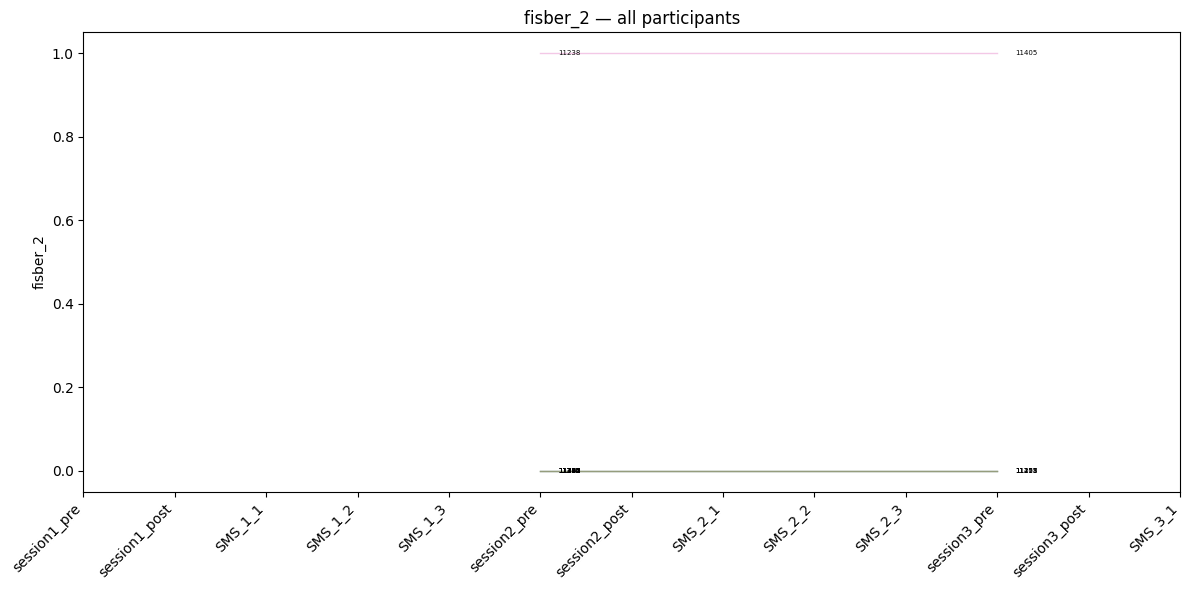

No worsening detected across the sample.


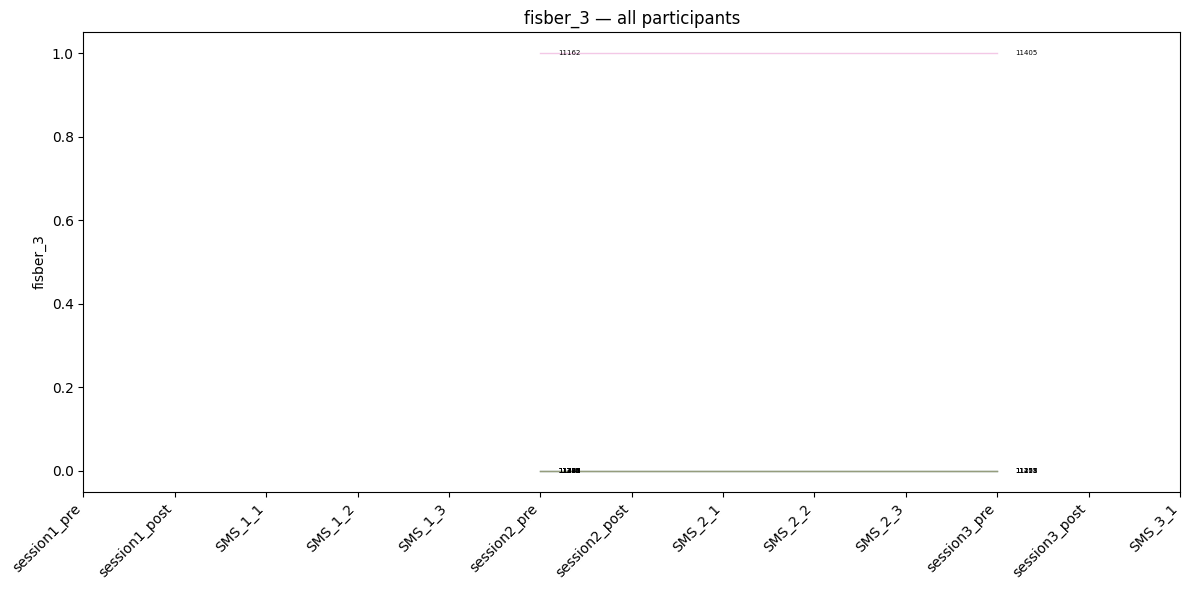

No worsening detected across the sample.


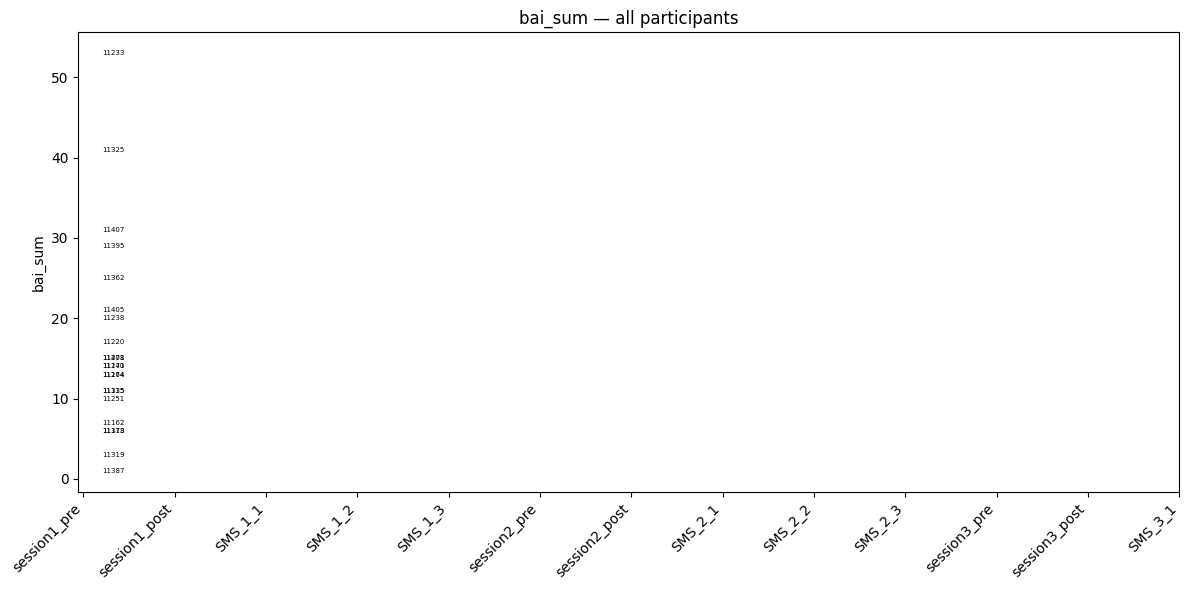

No worsening detected across the sample.


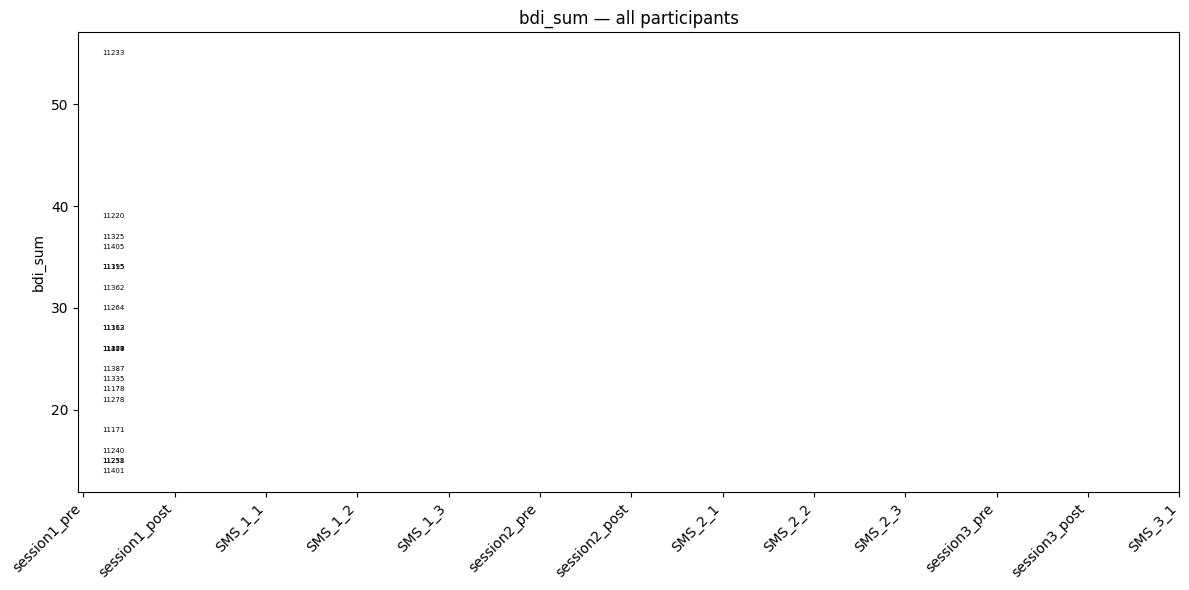

No worsening detected across the sample.


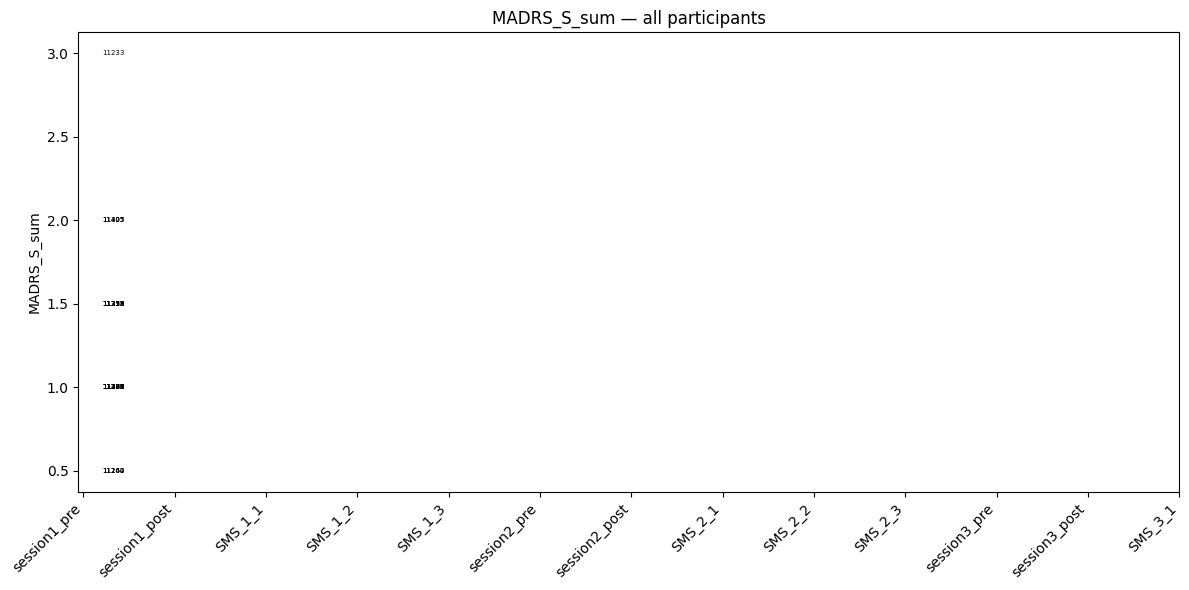

No worsening detected across the sample.


In [35]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#####
# 0) SETTINGS
#####
DATA_DIR = Path('/content')

#####
# 1) UTILITY TO FIND EXACTLY ONE CSV
#####
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 1b) TRY TO LOAD A CSV, BUT SKIP IF MISSING OR AMBIGUOUS
#####
def try_load(substring: str) -> pd.DataFrame | None:
    try:
        path = find_csv(substring)
    except (FileNotFoundError, ValueError) as e:
        print(f"Skipping '{substring}': {e}")
        return None
    print(f"Loaded '{substring}' from {path.name}")
    return pd.read_csv(path, dtype=str)

#####
# 2) LOAD ALL WELLBEING CSVS (skipping any that aren’t there yet)
#####
df_s1_pre     = try_load('pre_session_1')
df_s2to4_pre  = try_load('pre_sessions_2-4')
df_s2to4_post = try_load('post_sessions_1-3')
df_s4_post    = try_load('post_session_4')
df_sms        = try_load('sms_day1,3,5')
df_final      = try_load('sms_post')

# Collect only the ones that actually loaded
all_dfs = [df for df in (
    df_s1_pre,
    df_s2to4_pre,
    df_s2to4_post,
    df_s4_post,
    df_sms,
    df_final
) if df is not None]

if not all_dfs:
    raise RuntimeError("No data files found to process!")

#####
# 3) CLEAN BDI ITEMS (extract leading number)
#####
for df in all_dfs:
    bdi_raw = [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]
    for col in bdi_raw:
        df[col] = (
            df[col].astype(str)
                  .str.extract(r'^(\d+)')[0]
                  .astype(float)
        )

#####
# 4) SUM SCALES
#####
def sum_scale(df, cols, new_col):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[new_col] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

for df in all_dfs:
    # BAI
    bai_cols = get_scale_cols(df, 'bai', 21)
    if bai_cols:
        sum_scale(df, bai_cols, 'bai_sum')
    # BDI
    bdi_cols = get_scale_cols(df, 'bdi', 21)
    if bdi_cols:
        sum_scale(df, bdi_cols, 'bdi_sum')
    # MADRS
    madrs_cols = get_scale_cols(df, 'madrs', 9, allow_suffix=True)
    if madrs_cols:
        sum_scale(df, madrs_cols, 'MADRS_S_sum')

#####
# 5) STANDARDIZE M3VAS
#####
def standardize_m3vas(df):
    to_drop = []
    for var in ('suicidal','mood','pleasure'):
        # find change‐score first, then raw‐score
        ch_col  = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_ch_{var}(?:_1)?", c)), None)
        raw_col = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_{var}(?:_1)?",    c)), None)

        if ch_col:
            vals = pd.to_numeric(df[ch_col], errors='coerce') - 50
            to_drop.append(ch_col)
        elif raw_col:
            vals = pd.to_numeric(df[raw_col], errors='coerce') - 50
            to_drop.append(raw_col)
        else:
            continue

        if var == 'suicidal':
            # leave as-is: + means more suicidal (worse), so improvement → down
            df[f"m3vas_{var}"] = vals
        else:
            # mood & pleasure: + means improvement, so flip sign
            df[f"m3vas_{var}"] = -vals

    # drop only the original raw/change columns
    df.drop(columns=to_drop, inplace=True, errors='ignore')

# apply to each dataframe
for df in all_dfs:
    standardize_m3vas(df)

#####
# 6) CLEAN FISBER
#####
for df in all_dfs:
    for col in ('fisber_1','fisber_2','fisber_3'):
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                       .str.extract(r'(\d+)$')[0]
                       .astype(float)
            )

#####
# 7) COERCE TYPES
#####
# session_n for sessions
for df in (df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post):
    if df is not None and 'session_n' in df.columns:
        df['session_n'] = pd.to_numeric(df['session_n'], errors='coerce').astype('Int64')

# session_n & sms_n for SMS
if df_sms is not None:
    for col in ('session_n','sms_n'):
        if col in df_sms.columns:
            df_sms[col] = pd.to_numeric(df_sms[col], errors='coerce').astype('Int64')

# numeric scales
numeric_cols = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for df in all_dfs:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# 8) ENSURE EVERY DF HAS part_id
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)
    df['part_id'] = df['part_id'].astype(str).str.strip()

#####
# 9) TAG TIMEPOINTS
#####
if df_s1_pre    is not None: df_s1_pre    ['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None: df_s2to4_pre ['timepoint'] = df_s2to4_pre.apply(lambda r: f"session{r.session_n}_pre",  axis=1)
if df_s2to4_post is not None: df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
if df_s4_post   is not None: df_s4_post   ['timepoint'] = 'session4_post'
if df_sms       is not None: df_sms       ['timepoint'] = df_sms.apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
if df_final     is not None: df_final     ['timepoint'] = 'final_post'

#####
# 10) CONCATENATE
#####
df_long = pd.concat(all_dfs, ignore_index=True)

#####
# 11) DROP NON-NUMERIC part_id
#####
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

#####
# 12) MERGE IN CONDITION (if assignments file was found)
#####
df_assign = try_load('wp2_assignments')
if df_assign is not None:
    df_long = df_long.merge(
        df_assign[['part_id','condition']],
        on='part_id',
        how='inner'
    )
else:
    print("No assignments file: skipping merge with 'condition' column")

#####
# 13) DEFINE & APPLY ORDERED CATEGORICAL FOR timepoint
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)

#####
# 14) PLOTTING + FLAGGING ACROSS ALL PARTICIPANTS (BLINDED)
#####
bad_if_higher = {
    'phq9_sum',
    'spane_n',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum',
    'm3vas_suicidal'   # higher = more suicidal = worse
}

bad_if_lower = {
    'spane_p',
    'm3vas_mood',      # higher = better mood, so a drop is worsening
    'm3vas_pleasure'   # higher = better pleasure, so a drop is worsening
}

mcid_thresholds = {
    'phq9_sum': 5,
    'spane_p': 2,
    'spane_n': 2,
    'm3vas_mood': 12,
    'm3vas_pleasure': 12,
    'm3vas_suicidal': 12
}

#####
# ADJUST M3VAS SO 50 → 0 (“no change”), 0 → –50 (worse), 100 → +50 (better)
#####
def standardize_m3vas(df):
    for var in ('suicidal','mood','pleasure'):
        # detect the two possible inputs
        raw_col = next((c for c in df.columns
                        if re.fullmatch(f"m3vas_{var}(?:_1)?", c)), None)
        ch_col  = next((c for c in df.columns
                        if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)),  None)

        if raw_col is not None:
            # pre‐session raw VAS: 0 (best) → 100 (worst)
            vals = pd.to_numeric(df[raw_col], errors='coerce') - 50
        elif ch_col is not None:
            # post‐session change VAS: already –50 (better) → +50 (worse)
            vals = pd.to_numeric(df[ch_col], errors='coerce')
        else:
            continue

        # for mood & pleasure, invert so higher = more distress
        if var in ('mood','pleasure'):
            vals = -vals

        df[f"m3vas_{var}"] = vals

    # drop all the old raw / ch columns
    drop_re = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?"
        r"|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_re.match(c)]
    df.drop(columns=to_drop, errors='ignore', inplace=True)

# Apply to each dataframe
for df in all_dfs:
    standardize_m3vas(df)

#####
# PLOTTING & FLAGGING FUNCTION
#####
def plot_trajectories_and_flag(measure):
    if measure not in df_long.columns:
        print(f"→ skipping '{measure}': not in df_long")
        return

    # 1) Copy & drop session*_post for PHQ-9 and SPANE scales
    df_plot = df_long.copy()
    if measure in ('phq9_sum','spane_p','spane_n'):
        mask = df_plot['timepoint'].astype(str).str.match(r'^session\d+_post$')
        df_plot = df_plot[~mask]

    # 2) Determine which timepoints remain, preserving order
    timepoints_present = [tp for tp in ordered_timepoints if tp in df_plot['timepoint'].values]
    code_map = {tp: i for i, tp in enumerate(ordered_timepoints)}

    # 3) Plot trajectories
    fig, ax = plt.subplots(figsize=(12,6))
    for pid, grp in df_plot.groupby('part_id'):
        s = grp.dropna(subset=['timepoint', measure]).sort_values('timepoint')
        if s.empty:
            continue
        x = s['timepoint'].cat.codes
        y = s[measure].astype(float)
        ax.plot(x, y, linewidth=1, alpha=0.4)
        ax.text(x.iloc[-1] + 0.2, y.iloc[-1], pid, fontsize=5, va='center')

    # 4) Set ticks only for the retained timepoints
    tick_locs   = [code_map[tp] for tp in timepoints_present]
    tick_labels = timepoints_present
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')

    ax.set_ylabel(measure)
    ax.set_title(f"{measure} — all participants")
    plt.tight_layout()
    plt.show()

    # 5) Flag first MCID‐level worsening events
    if measure in mcid_thresholds:
        th = mcid_thresholds[measure]
        breach_events = []

        for pid, grp_pid in df_plot.groupby('part_id'):
            seq = (
                grp_pid
                .dropna(subset=['timepoint', measure])
                .sort_values('timepoint')
                .loc[:, ['part_id','timepoint', measure]]
                .assign(change=lambda d: d[measure] - d[measure].iloc[0])
            )
            if measure in bad_if_higher:
                mask = seq['change'] >= th
            else:
                mask = seq['change'] <= -th

            if mask.any():
                breach_events.append(seq[mask].iloc[0])

        if breach_events:
            df_breaches = pd.DataFrame(breach_events)
            print(f"First MCID‐level worsening events (threshold ≥ {th}):")
            display(df_breaches)
        else:
            print(f"No participants worsened by at least the MCID of {th} for {measure}.")

    else:
        # 6) Fallback: any participant whose final point is worse than their first
        worsened = []
        for pid, grp_pid in df_plot.groupby('part_id'):
            seq = grp_pid.dropna(subset=['timepoint', measure]) \
                         .sort_values('timepoint')[measure] \
                         .astype(float)
            if len(seq) < 2:
                continue
            if ((measure in bad_if_higher and seq.iloc[-1] > seq.iloc[0]) or
                (measure in bad_if_lower  and seq.iloc[-1] < seq.iloc[0])):
                worsened.append(pid)

        if worsened:
            print("Worsened trajectories (blinded):")
            display(
                df_plot[df_plot['part_id'].isin(worsened)]
                       [['part_id','timepoint',measure]]
                       .dropna(subset=[measure])
                       .sort_values(['part_id','timepoint'])
                       .reset_index(drop=True)
            )
        else:
            print("No worsening detected across the sample.")

#####
# RUN FOR ALL MEASURES
#####
for m in measures:
    plot_trajectories_and_flag(m)

Mean Tolerability ± SD Assessment Across Sessions (Whole-Sample & Just-Adverse)
*   run previous monitoring and stratification scripts first to generate necessary dfs

In [8]:
import numpy as np
import pandas as pd
from pathlib import Path

#####
# 0) Load and clean all post-session data (sessions 1–4)
#####
from pathlib import Path
import glob

DATA_DIR = Path('/content')
# Glob all post-session CSVs (e.g. sessions 1-3 and session 4)
post_files = sorted(str(f) for f in DATA_DIR.glob('wp2_post_session*csv'))

# Read each file, skip metadata row, and assign timepoint
frames = []
for fpath in post_files:
    temp = pd.read_csv(fpath, header=0, skiprows=[1], dtype=str)
    temp.columns = temp.columns.str.strip()
    temp['part_id'] = temp['part_id'].astype(str).str.strip()
    # If session_n column present, map it
    if 'session_n' in temp.columns:
        temp['session_n'] = pd.to_numeric(temp['session_n'], errors='coerce')
        temp['timepoint'] = temp['session_n'].apply(lambda x: f'session{int(x)}_post' if pd.notna(x) else None)
    else:
        # infer session4_post from filename
        temp['timepoint'] = 'session4_post'
    frames.append(temp)

# Concatenate all sessions
df_raw = pd.concat(frames, ignore_index=True)

#####
# 1) Compute tol_score (max across all tol_follow items)
##### tol_score per row (max across all tol_follow items)
#####
tol_cols = [c for c in df_raw.columns if c.lower().startswith('tol_follow')]
for col in tol_cols:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce').fillna(0)

df_raw['tol_score'] = df_raw[tol_cols].max(axis=1)

#####
# 2) Merge in condition assignments
#####
assign = pd.read_csv('wp2_assignments.csv', dtype=str)[['part_id','condition']]
df = df_raw.merge(assign, on='part_id', how='left')

#####
# 3) Summarize per-participant-session
#####
tol_summary = (
    df
      .groupby(['part_id','condition','timepoint'], observed=False)
      .agg(tol_score=('tol_score', 'max'))
      .reset_index()
)

#####
# 4a) Mean ± SD including zeros, by arm and session
#####
tol_stats_all = (
    tol_summary
      .groupby(['condition','timepoint'], observed=False)
      .agg(
          tol_mean_all=('tol_score', 'mean'),
          tol_sd_all=('tol_score', 'std')
      )
      .round(2)
      .reset_index()
)

print("Tolerability score including zeros (mean ± SD), by condition and session:")
display(
    tol_stats_all.pivot(
        index='condition',
        columns='timepoint',
        values=['tol_mean_all','tol_sd_all']
    )
)

#####
# 4b) Mean ± SD & N among those with any side effect (tol_score > 0)
#####
tol_stats_nonzero = (
    tol_summary[tol_summary['tol_score'] > 0]
      .groupby(['condition','timepoint'], observed=False)
      .agg(
          tol_mean_nonzero=('tol_score', 'mean'),
          tol_sd_nonzero=('tol_score', lambda x: x.std(ddof=0)),
          n_side_effects=('tol_score', 'count')
      )
      .round(2)
      .reset_index()
)

print("Tolerability score among those with side effects (mean ± SD, N), by condition and session:")
display(
    tol_stats_nonzero.pivot(
        index='condition',
        columns='timepoint',
        values=['tol_mean_nonzero','tol_sd_nonzero','n_side_effects']
    )
)

Tolerability score including zeros (mean ± SD), by condition and session:


tol_mean_all                                tol_sd_all  \
timepoint    session1_post session2_post session3_post session1_post   
condition                                                              
control               0.44          0.38           0.0          1.33   
intervention          0.31          0.00           0.0          0.85   

                                          
timepoint    session2_post session3_post  
condition                                 
control               0.74           0.0  
intervention          0.00           NaN

Tolerability score among those with side effects (mean ± SD, N), by condition and session:


tol_mean_nonzero               tol_sd_nonzero                \
timepoint       session1_post session2_post  session1_post session2_post   
condition                                                                  
control                   4.0           1.5            0.0           0.5   
intervention              2.0           NaN            1.0           NaN   

             n_side_effects                
timepoint     session1_post session2_post  
condition                                  
control                 1.0           2.0  
intervention            2.0           NaN

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 7.765806
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        phq9_sum 
No. Observations:          118            Method:                    REML     
No. Groups:                22             Scale:                     6.5104   
Min. group size:           2              Log-Likelihood:            -311.4402
Max. group size:           10             Converged:                 No       
Mean group size:           5.4                                                
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           10.325    1.442  7.159 0.000  7.498 13.152
condition[T.intervention]            2.227    1.931  1.153 0.249 -1.558  6.012
time_num                            -0.185    0.145 -1.279 0.201 -0.470  

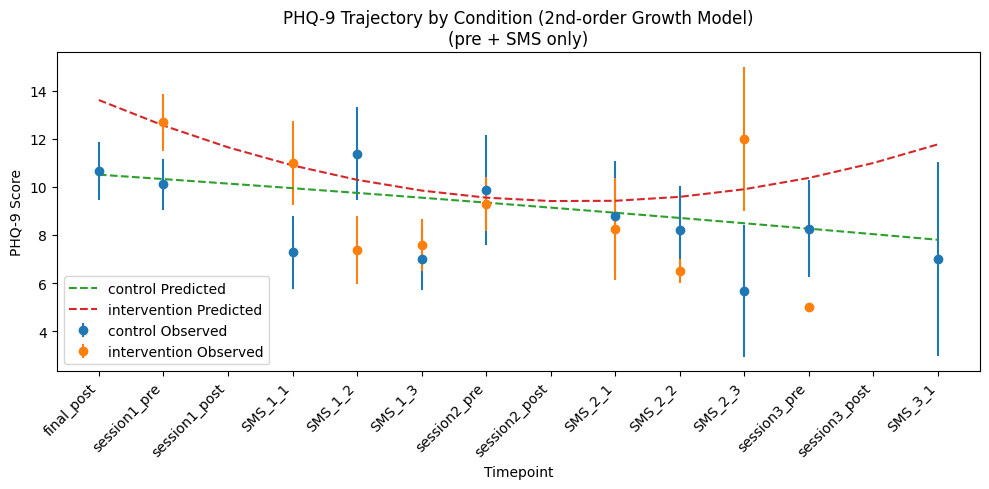

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.formula.api as smf

#####
# 0) SETTINGS
#####
DATA_DIR = Path('/content')

#####
# 1) UTILITIES TO LOAD CSVs
#####
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}'")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

def try_load(substring: str) -> pd.DataFrame | None:
    try:
        path = find_csv(substring)
    except (FileNotFoundError, ValueError):
        return None
    return pd.read_csv(path, dtype=str)

# Load dataframes
df_s1_pre     = try_load('pre_session_1')
df_s2to4_pre  = try_load('pre_sessions_2-4')
df_s2to4_post = try_load('post_sessions_1-3')
df_s4_post    = try_load('post_session_4')
df_sms        = try_load('sms_day1,3,5')
df_final      = try_load('sms_post')

all_dfs = [df for df in (
    df_s1_pre, df_s2to4_pre, df_s2to4_post,
    df_s4_post, df_sms, df_final
) if df is not None]
if not all_dfs:
    raise RuntimeError("No data files found to process!")

#####
# 2) CLEAN & SUM SCALES (BDI, BAI, MADRS)
#####
def sum_scale(df, cols, out):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[out] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

for df in all_dfs:
    # extract numeric from BDI
    for col in [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]:
        df[col] = df[col].astype(str).str.extract(r"^(\d+)")[0].astype(float)
    # BAI
    bai = get_scale_cols(df, 'bai', 21)
    if bai: sum_scale(df, bai, 'bai_sum')
    # BDI
    bdi = get_scale_cols(df, 'bdi', 21)
    if bdi: sum_scale(df, bdi, 'bdi_sum')
    # MADRS
    madrs = get_scale_cols(df, 'madrs', 9, allow_suffix=True)
    if madrs: sum_scale(df, madrs, 'MADRS_S_sum')

#####
# 3) STANDARDIZE M3VAS TO –50…+50
#####
def standardize_m3vas(df):
    for var in ('suicidal','mood','pleasure'):
        raw = next((c for c in df.columns if re.fullmatch(f"m3vas_{var}(?:_1)?", c)), None)
        ch  = next((c for c in df.columns if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)),  None)
        if var == 'suicidal':
            if raw is not None:
                df['m3vas_suicidal'] = pd.to_numeric(df[raw], errors='coerce') - 50
            elif ch is not None:
                df['m3vas_suicidal'] = pd.to_numeric(df[ch],  errors='coerce') - 50
        else:
            if raw is not None:
                df[f"m3vas_{var}"] = 50 - pd.to_numeric(df[raw], errors='coerce')
            elif ch is not None:
                df[f"m3vas_{var}"] = pd.to_numeric(df[ch], errors='coerce') - 50
    # drop old raw / change columns
    drop_pattern = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_pattern.match(c)]
    df.drop(columns=to_drop, errors='ignore', inplace=True)

for df in all_dfs:
    standardize_m3vas(df)

#####
# 4) CLEAN FISBER & COERCE TYPES
#####
for df in all_dfs:
    for c in ('fisber_1','fisber_2','fisber_3'):
        if c in df.columns:
            df[c] = df[c].astype(str).str.extract(r"(\d+)$")[0].astype(float)
    # numeric scales
    for col in [
        'phq9_sum','spane_p','spane_n',
        'm3vas_suicidal','m3vas_mood','m3vas_pleasure',
        'fisber_1','fisber_2','fisber_3',
        'bai_sum','bdi_sum','MADRS_S_sum'
    ]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# 5) ENSURE part_id & TAG TIMEPOINTS
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)
    df['part_id'] = df['part_id'].astype(str).str.strip()

if df_s1_pre is not None:
    df_s1_pre['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None:
    df_s2to4_pre['timepoint'] = df_s2to4_pre.apply(
        lambda r: f"session{r.session_n}_pre", axis=1
    )
if df_s2to4_post is not None:
    df_s2to4_post['timepoint'] = df_s2to4_post.apply(
        lambda r: f"session{r.session_n}_post", axis=1
    )
if df_s4_post is not None:
    df_s4_post['timepoint'] = 'session4_post'
if df_sms is not None:
    df_sms['timepoint'] = df_sms.apply(
        lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1
    )
if df_final is not None:
    df_final['timepoint'] = 'final_post'

# Concatenate
df_long = pd.concat(all_dfs, ignore_index=True)
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

# Merge condition assignments if available
df_assign = try_load('wp2_assignments')
if df_assign is not None:
    df_long = df_long.merge(df_assign[['part_id','condition']],
                            on='part_id', how='inner')

#####
# 6) ORDER TIMEPOINTS & CREATE TIME VARIABLES
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'], categories=ordered_timepoints, ordered=True
)
df_long['time_num']  = df_long['timepoint'].cat.codes
df_long['time_num2'] = df_long['time_num']**2

# — after df_long['time_num2'] = df_long['time_num']**2 —

# 7a) EXCLUDE ALL sessionN_post TIMEPOINTS FOR THE PHQ-9 MODEL
mask_post = df_long['timepoint'].astype(str).str.match(r'^session\d+_post$')
df_model = df_long[~mask_post].copy()

#####
# 7b) FIT 2ND-ORDER MIXED-EFFECTS GROWTH MODEL FOR PHQ-9 (pre + SMS only)
#####
model = smf.mixedlm(
    "phq9_sum ~ time_num * condition + time_num2 * condition",
    data=df_model,                # use df_model, not df_long
    groups="part_id",
    re_formula="~time_num"
)
res = model.fit(method='lbfgs')
print(res.summary())

#####
# 8) PLOT OBSERVED MEANS ± SEM AND MODEL PREDICTIONS (pre + SMS only)
#####
# Observed summary on df_model
obs = (
    df_model
    .groupby(['condition','time_num'])['phq9_sum']
    .agg(['mean','sem'])
    .reset_index()
)

# Prediction grid stays the same
time_vals = np.arange(df_model['time_num'].min(),
                      df_model['time_num'].max()+1)
conds     = df_model['condition'].dropna().unique()
pred = pd.DataFrame([
    {'time_num': t, 'time_num2': t**2, 'condition': c}
    for c in conds for t in time_vals
])
pred['predicted'] = res.predict(pred)

# Plot
plt.figure(figsize=(10,5))
for cond, grp in obs.groupby('condition'):
    plt.errorbar(grp['time_num'], grp['mean'], yerr=grp['sem'],
                 fmt='o', label=f"{cond} Observed")
for cond in conds:
    sub = pred[pred['condition']==cond]
    plt.plot(sub['time_num'], sub['predicted'], '--',
             label=f"{cond} Predicted")

# Only label the timepoints actually in df_model
labels = [ordered_timepoints[i] for i in time_vals]
plt.xticks(time_vals, labels, rotation=45, ha='right')

plt.xlabel("Timepoint")
plt.ylabel("PHQ-9 Score")
plt.title("PHQ-9 Trajectory by Condition (2nd-order Growth Model)\n(pre + SMS only)")
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
model_lin = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"   # random intercept only
)
res_lin = model_lin.fit(method='lbfgs', reml=False)
print(res_lin.summary())

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      phq9_sum 
No. Observations:       118          Method:                  ML       
No. Groups:             22           Scale:                   6.7145   
Min. group size:        2            Log-Likelihood:          -306.9715
Max. group size:        10           Converged:               Yes      
Mean group size:        5.4                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     9.498    1.336  7.111 0.000  6.880 12.116
condition[T.intervention]     0.818    1.761  0.465 0.642 -2.633  4.270
tc                           -0.217    0.108 -2.013 0.044 -0.428 -0.006
tc:condition[T.intervention] -0.182    0.179 -1.018 0.309 -0.532  0.168
part_id V

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      phq9_sum 
No. Observations:       118          Method:                  REML     
No. Groups:             22           Scale:                   6.8460   
Min. group size:        2            Log-Likelihood:          -306.9963
Max. group size:        10           Converged:               Yes      
Mean group size:        5.4                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     9.500    1.408  6.749 0.000  6.741 12.259
condition[T.intervention]     0.829    1.854  0.447 0.655 -2.805  4.462
tc                           -0.217    0.109 -1.992 0.046 -0.431 -0.004
tc:condition[T.intervention] -0.179    0.181 -0.993 0.321 -0.533  0.175
part_id V

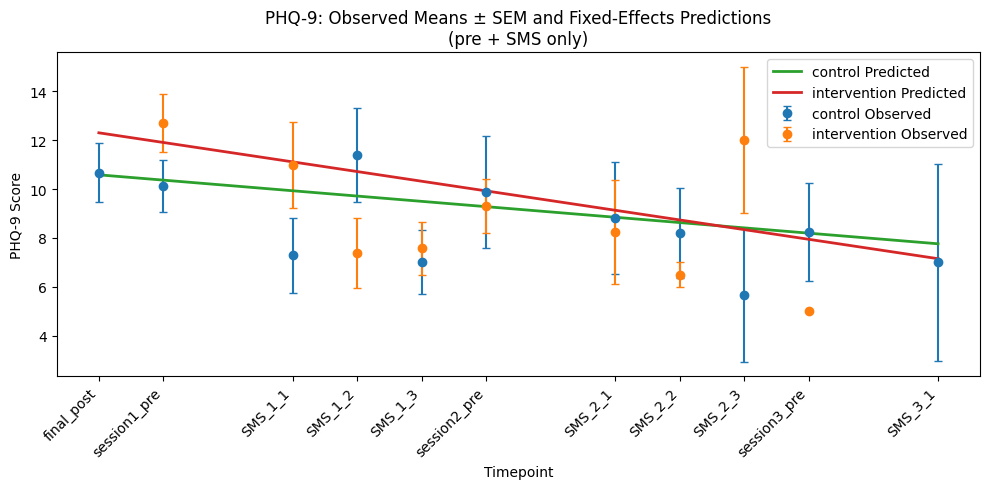

In [37]:
# 6) ORDER TIMEPOINTS & CREATE TIME VARIABLES
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)
df_long['time_num'] = df_long['timepoint'].cat.codes

# center time
df_long['tc'] = df_long['time_num'] - df_long['time_num'].mean()

# 7) EXCLUDE sessionN_post FOR THE PHQ-9 LINEAR MODEL
# (so you only model pre + SMS assessments)
mask_post = df_long['timepoint'].astype(str).str.match(r'^session\d+_post$')
df_model = df_long[~mask_post].copy()

import statsmodels.formula.api as smf

# Random‐intercepts‐only linear growth with centered time
model0 = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,        # use df_model, not df_long
    groups="part_id",
    re_formula="~1"
)
res0 = model0.fit(method='lbfgs')
print(res0.summary())

import matplotlib.pyplot as plt

# 1) Observed means + SEM by condition & time_num (on df_model)
obs = (
    df_model
    .groupby(['condition','time_num'])['phq9_sum']
    .agg(['mean','sem'])
    .reset_index()
)

# 2) Fixed‐effects predictions from the random‐intercepts model
fe = res0.fe_params
mean_time = df_model['time_num'].mean()
preds = []
conds = df_model['condition'].dropna().unique()
time_vals = sorted(df_model['time_num'].unique())

for cond in conds:
    is_int = int(cond == 'intervention')
    for t in time_vals:
        tc = t - mean_time
        pred = (
            fe['Intercept']
            + fe.get('condition[T.intervention]', 0) * is_int
            + fe['tc'] * tc
            + fe.get('tc:condition[T.intervention]', 0) * tc * is_int
        )
        preds.append({'condition': cond, 'time_num': t, 'predicted': pred})

pred_df = pd.DataFrame(preds)

# 3) Plot
plt.figure(figsize=(10,5))
for cond, grp in obs.groupby('condition'):
    plt.errorbar(
        grp['time_num'], grp['mean'], yerr=grp['sem'],
        fmt='o', capsize=3, label=f"{cond} Observed"
    )
for cond in conds:
    sub = pred_df[pred_df['condition']==cond]
    plt.plot(
        sub['time_num'], sub['predicted'], '-',
        lw=2, label=f"{cond} Predicted"
    )

# xticks: only the timepoints in df_model
labels = [ordered_timepoints[i] for i in time_vals]
plt.xticks(time_vals, labels, rotation=45, ha='right')

plt.xlabel("Timepoint")
plt.ylabel("PHQ-9 Score")
plt.title("PHQ-9: Observed Means ± SEM and Fixed-Effects Predictions\n(pre + SMS only)")
plt.legend()
plt.tight_layout()
plt.show()

Loaded 'pre_session_1' from wp2_pre_session_1_July 2, 2025_09.36.csv
Loaded 'pre_sessions_2-4' from wp2_pre_sessions_2-4_July 2, 2025_09.36.csv
Loaded 'post_sessions_1-3' from wp2_post_sessions_1-3_July 2, 2025_09.35.csv
Skipping 'post_session_4': No file matching 'post_session_4' in /content
Loaded 'sms_day1,3,5' from wp2_sms_day1,3,5_July 2, 2025_09.36.csv
Skipping 'sms_post': No file matching 'sms_post' in /content
Loaded 'wp2_assignments' from wp2_assignments.csv


/tmp/ipython-input-7-3476020673.py:322: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


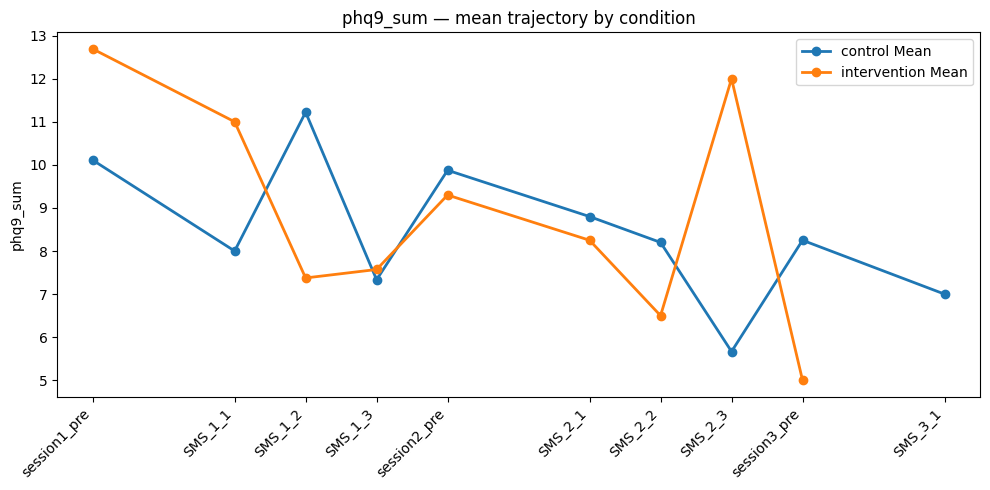

/tmp/ipython-input-7-3476020673.py:322: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


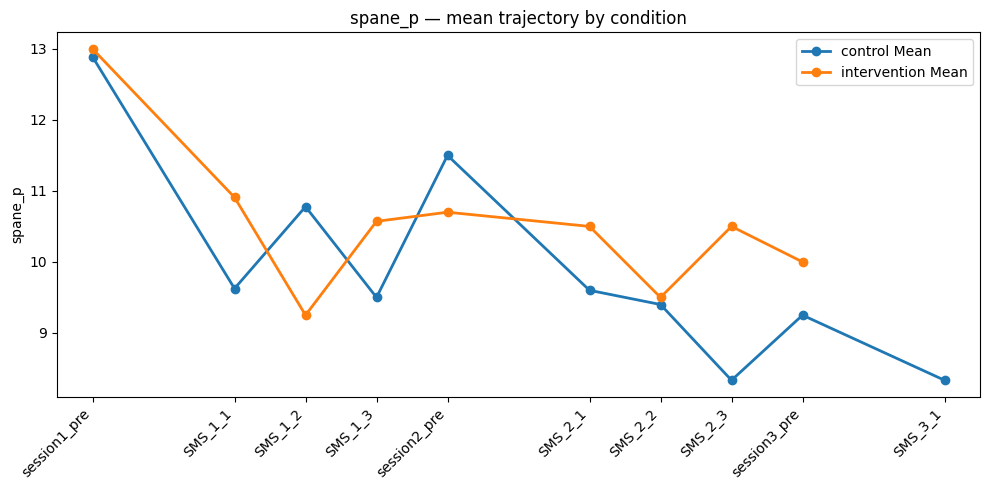

/tmp/ipython-input-7-3476020673.py:322: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


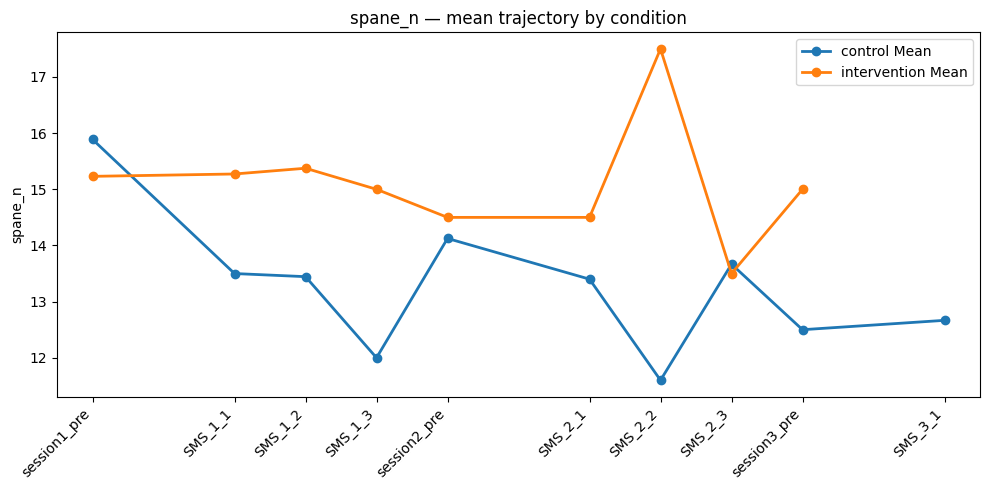

/tmp/ipython-input-7-3476020673.py:322: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


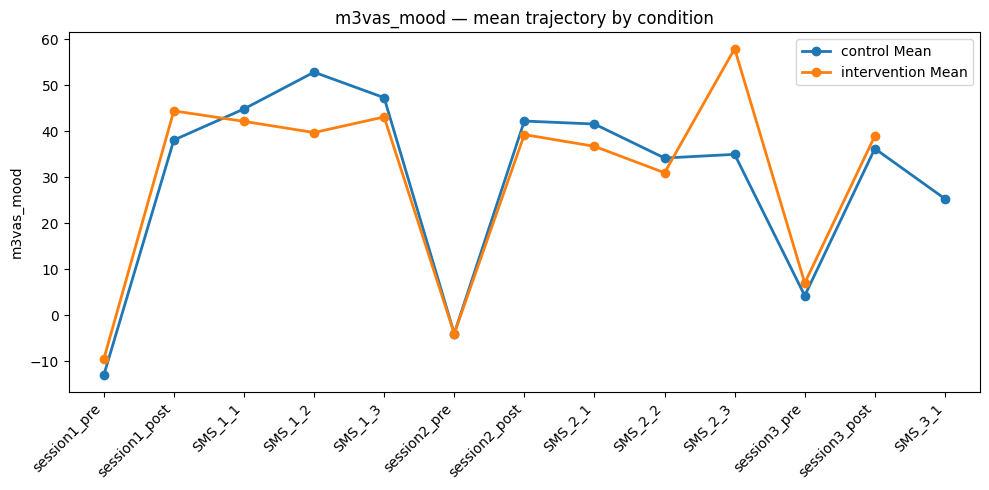

/tmp/ipython-input-7-3476020673.py:322: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


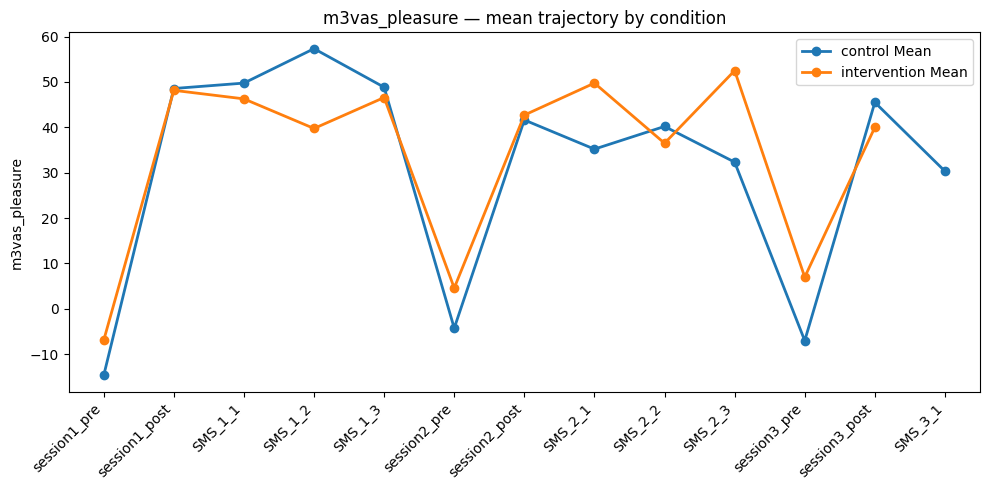

/tmp/ipython-input-7-3476020673.py:322: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


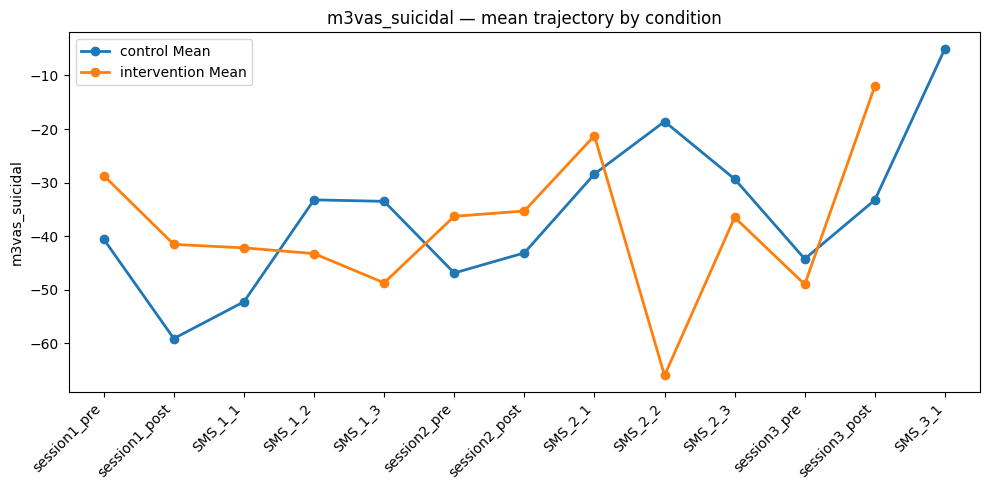

/tmp/ipython-input-7-3476020673.py:322: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


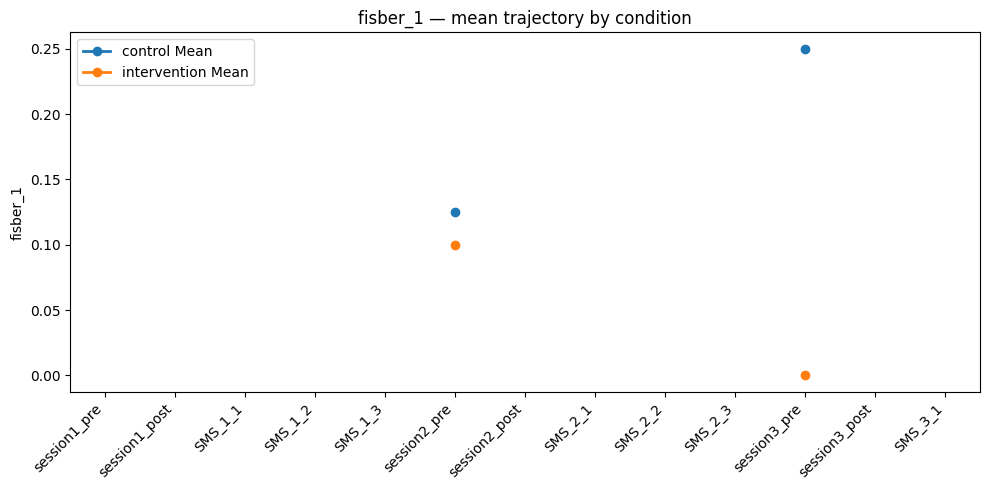

/tmp/ipython-input-7-3476020673.py:322: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


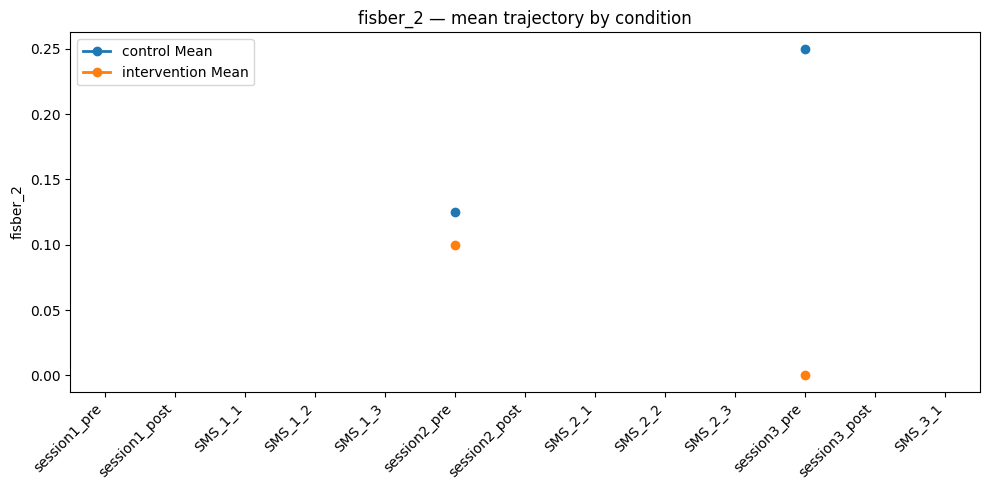

/tmp/ipython-input-7-3476020673.py:322: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


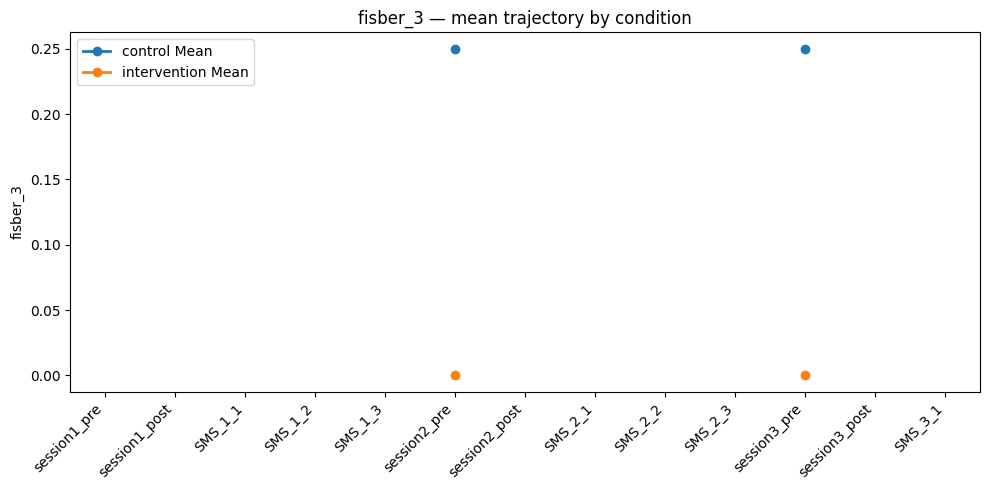

/tmp/ipython-input-7-3476020673.py:322: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


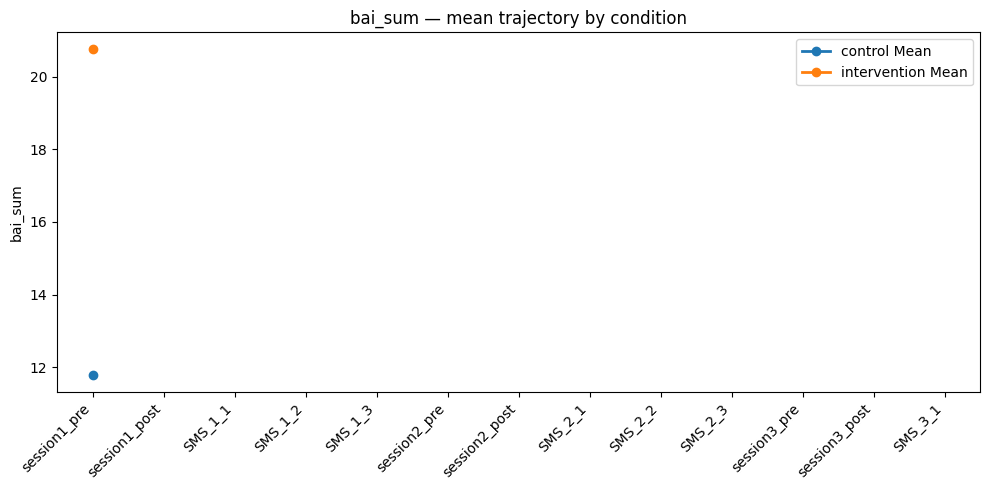

/tmp/ipython-input-7-3476020673.py:322: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


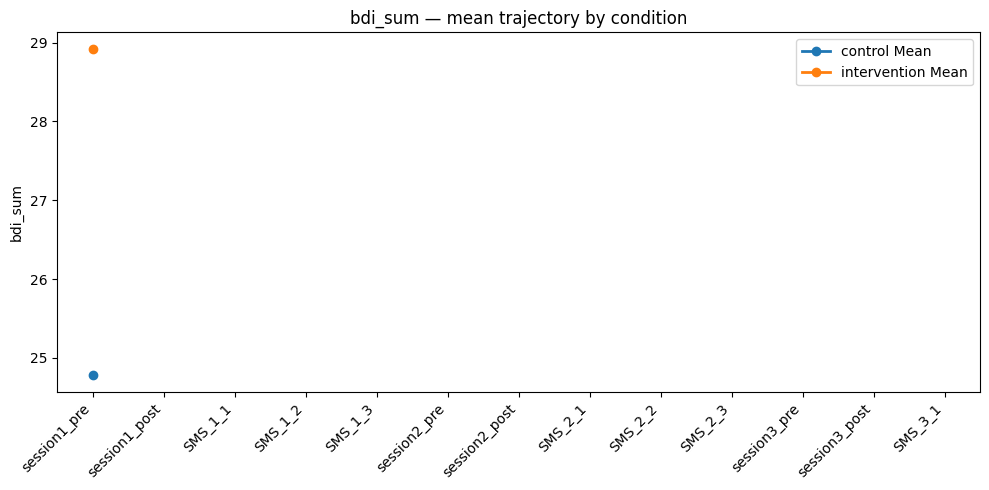

/tmp/ipython-input-7-3476020673.py:322: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


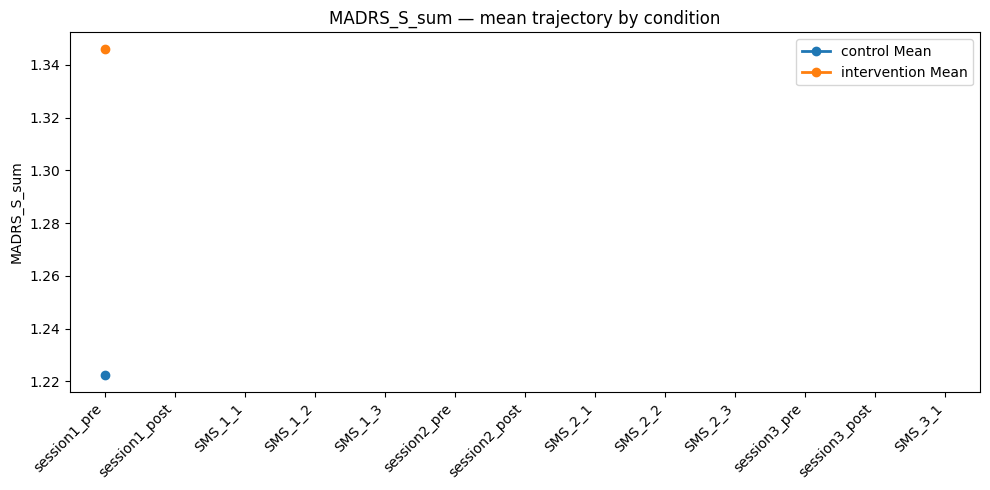

In [7]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#####
# 0) SETTINGS
#####
DATA_DIR = Path('/content')

#####
# 1) UTILITY TO FIND EXACTLY ONE CSV
#####
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 1b) TRY TO LOAD A CSV, BUT SKIP IF MISSING OR AMBIGUOUS
#####
def try_load(substring: str) -> pd.DataFrame | None:
    try:
        path = find_csv(substring)
    except (FileNotFoundError, ValueError) as e:
        print(f"Skipping '{substring}': {e}")
        return None
    print(f"Loaded '{substring}' from {path.name}")
    return pd.read_csv(path, dtype=str)

#####
# 2) LOAD ALL WELLBEING CSVS (skipping any that aren’t there yet)
#####
df_s1_pre     = try_load('pre_session_1')
df_s2to4_pre  = try_load('pre_sessions_2-4')
df_s2to4_post = try_load('post_sessions_1-3')
df_s4_post    = try_load('post_session_4')
df_sms        = try_load('sms_day1,3,5')
df_final      = try_load('sms_post')

# Collect only the ones that actually loaded
all_dfs = [df for df in (
    df_s1_pre,
    df_s2to4_pre,
    df_s2to4_post,
    df_s4_post,
    df_sms,
    df_final
) if df is not None]

if not all_dfs:
    raise RuntimeError("No data files found to process!")

#####
# 3) CLEAN BDI ITEMS (extract leading number)
#####
for df in all_dfs:
    bdi_raw = [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]
    for col in bdi_raw:
        df[col] = (
            df[col].astype(str)
                  .str.extract(r'^(\d+)')[0]
                  .astype(float)
        )

#####
# 4) SUM SCALES
#####
def sum_scale(df, cols, new_col):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[new_col] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

for df in all_dfs:
    # BAI
    bai_cols = get_scale_cols(df, 'bai', 21)
    if bai_cols:
        sum_scale(df, bai_cols, 'bai_sum')
    # BDI
    bdi_cols = get_scale_cols(df, 'bdi', 21)
    if bdi_cols:
        sum_scale(df, bdi_cols, 'bdi_sum')
    # MADRS
    madrs_cols = get_scale_cols(df, 'madrs', 9, allow_suffix=True)
    if madrs_cols:
        sum_scale(df, madrs_cols, 'MADRS_S_sum')

#####
# 5) STANDARDIZE M3VAS
#####
def standardize_m3vas(df):
    to_drop = []
    for var in ('suicidal','mood','pleasure'):
        # find change‐score first, then raw‐score
        ch_col  = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_ch_{var}(?:_1)?", c)), None)
        raw_col = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_{var}(?:_1)?",    c)), None)

        if ch_col:
            vals = pd.to_numeric(df[ch_col], errors='coerce') - 50
            to_drop.append(ch_col)
        elif raw_col:
            vals = pd.to_numeric(df[raw_col], errors='coerce') - 50
            to_drop.append(raw_col)
        else:
            continue

        if var == 'suicidal':
            # leave as-is: + means more suicidal (worse), so improvement → down
            df[f"m3vas_{var}"] = vals
        else:
            # mood & pleasure: + means improvement, so flip sign
            df[f"m3vas_{var}"] = -vals

    # drop only the original raw/change columns
    df.drop(columns=to_drop, inplace=True, errors='ignore')

# apply to each dataframe
for df in all_dfs:
    standardize_m3vas(df)

#####
# 6) CLEAN FISBER
#####
for df in all_dfs:
    for col in ('fisber_1','fisber_2','fisber_3'):
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                       .str.extract(r'(\d+)$')[0]
                       .astype(float)
            )

#####
# 7) COERCE TYPES
#####
# session_n for sessions
for df in (df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post):
    if df is not None and 'session_n' in df.columns:
        df['session_n'] = pd.to_numeric(df['session_n'], errors='coerce').astype('Int64')

# session_n & sms_n for SMS
if df_sms is not None:
    for col in ('session_n','sms_n'):
        if col in df_sms.columns:
            df_sms[col] = pd.to_numeric(df_sms[col], errors='coerce').astype('Int64')

# numeric scales
numeric_cols = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for df in all_dfs:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# 8) ENSURE EVERY DF HAS part_id
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)
    df['part_id'] = df['part_id'].astype(str).str.strip()

#####
# 9) TAG TIMEPOINTS
#####
if df_s1_pre    is not None: df_s1_pre    ['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None: df_s2to4_pre ['timepoint'] = df_s2to4_pre.apply(lambda r: f"session{r.session_n}_pre",  axis=1)
if df_s2to4_post is not None: df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
if df_s4_post   is not None: df_s4_post   ['timepoint'] = 'session4_post'
if df_sms       is not None: df_sms       ['timepoint'] = df_sms.apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
if df_final     is not None: df_final     ['timepoint'] = 'final_post'

#####
# 10) CONCATENATE
#####
df_long = pd.concat(all_dfs, ignore_index=True)

#####
# 11) DROP NON-NUMERIC part_id
#####
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

#####
# 12) MERGE IN CONDITION (if assignments file was found)
#####
df_assign = try_load('wp2_assignments')
if df_assign is not None:
    df_long = df_long.merge(
        df_assign[['part_id','condition']],
        on='part_id',
        how='inner'
    )
else:
    print("No assignments file: skipping merge with 'condition' column")

#####
# 13) DEFINE & APPLY ORDERED CATEGORICAL FOR timepoint
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)

#####
# 14) PLOTTING + FLAGGING ACROSS ALL PARTICIPANTS (BLINDED)
#####
bad_if_higher = {
    'phq9_sum',
    'spane_n',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum',
    'm3vas_suicidal'   # higher = more suicidal = worse
}

bad_if_lower = {
    'spane_p',
    'm3vas_mood',      # higher = better mood, so a drop is worsening
    'm3vas_pleasure'   # higher = better pleasure, so a drop is worsening
}

mcid_thresholds = {
    'phq9_sum': 5,
    'spane_p': 2,
    'spane_n': 2,
    'm3vas_mood': 12,
    'm3vas_pleasure': 12,
    'm3vas_suicidal': 12
}

#####
# ADJUST M3VAS SO 50 → 0 (“no change”), 0 → –50 (worse), 100 → +50 (better)
#####
def standardize_m3vas(df):
    for var in ('suicidal','mood','pleasure'):
        # detect the two possible inputs
        raw_col = next((c for c in df.columns
                        if re.fullmatch(f"m3vas_{var}(?:_1)?", c)), None)
        ch_col  = next((c for c in df.columns
                        if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)),  None)

        if raw_col is not None:
            # pre‐session raw VAS: 0 (best) → 100 (worst)
            vals = pd.to_numeric(df[raw_col], errors='coerce') - 50
        elif ch_col is not None:
            # post‐session change VAS: already –50 (better) → +50 (worse)
            vals = pd.to_numeric(df[ch_col], errors='coerce')
        else:
            continue

        # for mood & pleasure, invert so higher = more distress
        if var in ('mood','pleasure'):
            vals = -vals

        df[f"m3vas_{var}"] = vals

    # drop all the old raw / ch columns
    drop_re = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?"
        r"|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_re.match(c)]
    df.drop(columns=to_drop, errors='ignore', inplace=True)

# Apply to each dataframe
for df in all_dfs:
    standardize_m3vas(df)

#####
# PLOTTING & FLAGGING FUNCTION
#####
def plot_mean_by_condition(measure):
    if measure not in df_long.columns:
        print(f"→ skipping '{measure}': not in df_long")
        return

    # 1) Filter out session*_post for PHQ-9 & SPANE
    df_plot = df_long.copy()
    if measure in ('phq9_sum','spane_p','spane_n'):
        mask = df_plot['timepoint'].astype(str).str.match(r'^session\d+_post$')
        df_plot = df_plot[~mask]

    # 2) Determine which timepoints remain, in order
    timepoints_present = [tp for tp in ordered_timepoints if tp in df_plot['timepoint'].values]
    code_map = {tp:i for i,tp in enumerate(ordered_timepoints)}

    # 3) Compute mean (and SEM, if you like) by condition
    mean_df = (
        df_plot
        .groupby(['timepoint','condition'])[measure]
        .mean()
        .unstack('condition')
        .reindex(timepoints_present)
    )
    # sem_df = df_plot.groupby(['timepoint','condition'])[measure].sem().unstack('condition').reindex(timepoints_present)

    # 4) Plot
    fig, ax = plt.subplots(figsize=(10,5))
    for cond in mean_df.columns:
        ax.plot(
            [code_map[tp] for tp in mean_df.index],
            mean_df[cond],
            marker='o', lw=2, label=f"{cond} Mean"
        )
        # To add error bars, uncomment:
        # eb = sem_df[cond]
        # ax.errorbar(
        #     [code_map[tp] for tp in mean_df.index],
        #     mean_df[cond], yerr=eb, fmt='none', capsize=3
        # )

    # 5) Ticks & labels
    locs  = [code_map[tp] for tp in timepoints_present]
    labs  = timepoints_present
    ax.set_xticks(locs)
    ax.set_xticklabels(labs, rotation=45, ha='right')
    ax.set_xlim(min(locs)-0.5, max(locs)+0.5)

    ax.set_ylabel(measure)
    ax.set_title(f"{measure} — mean trajectory by condition")
    ax.legend()
    plt.tight_layout()
    plt.show()

# RUN FOR ALL MEASURES
for m in measures:
    plot_mean_by_condition(m)